In [40]:
import os
import sys
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns
import nibabel as nib
import pickle
import torchvision.models as models
import nibabel as nib
import h5py
import scipy.stats.mstats as mstats
import copy

from nilearn import plotting
from scipy.ndimage import binary_dilation
from PIL import Image
from importlib import reload
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator, NullFormatter
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from colorama import Fore, Style
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.impute import SimpleImputer
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from tqdm import tqdm
from matplotlib.lines import Line2D
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from typing import Dict, Tuple, Union
from scipy.special import softmax



print(sys.path)
%pwd

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

from unet_recon.inpainting import UNet
from funcs.analyses import univariate_regression

['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode']


##### Reload to apply class changes

In [80]:
import importlib
from importlib import reload
import funcs.natspatpred
importlib.reload(funcs.natspatpred)
from funcs.natspatpred import NatSpatPred, VoxelSieve

soepstengesl


#### Load in the Naturalistic Spatial Predictions class

In [81]:
NSP = NatSpatPred()
NSP.initialise()

Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .datapath
 .explore
 .hidden_methods
 .initialise
 .stimuli
 .subjects
 .utils


In [7]:
rois, roi_masks, viscortex_mask = NSP.cortex.visrois_dict(verbose=False)
prf_dict = NSP.cortex.prf_dict(rois, roi_masks)

# WORK ON EFFICIENT PRF LOCALISATION 

##### This is a gorgeous class used to efficiently select voxels. It has a range of attributes that allow for efficient selections later on.

It is infinite times faster than the prf_heatmap function I used before

In [84]:
V1voxels = VoxelSieve(NSP, prf_dict, roi_masks, subject='subj01', roi='V1', max_size=1, min_size=.1, patchbound=1, min_nsd_R2=0, min_prf_R2=0)

In [85]:
NSP.cortex.plot_prfs(V1voxels)

There are 596 voxels left


##### Load in the roi masks, and the pRF dictionary with relevant parameter data

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


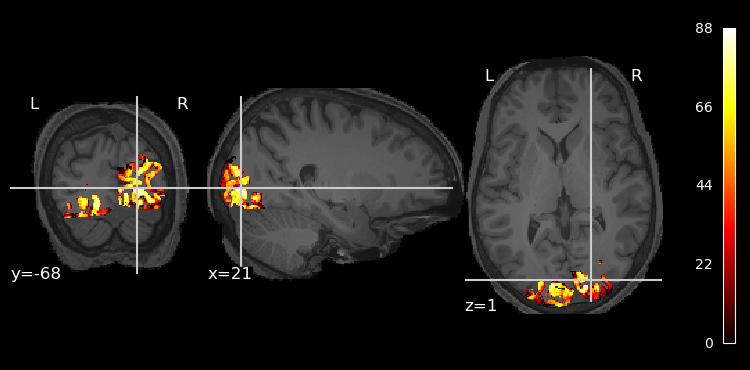

In [10]:
poep = NSP.utils.cap_values(prf_dict['subj01']['nsd_dat']['R2']['prf_ar'], 0, 100) * viscortex_mask.astype(bool)

NSP.analyse.plot_brain(prf_dict, roi_masks, 'subj01', poep, False)


#### Write method to load in these files rapidly an concatenate the [:,3:]

## Implement this in load_y --> A lot faster

In [119]:
# for roi in rois:
#     anus = NSP.datafetch._stack_betas('subj01',roi, True, 40)
#     np.save(f'/home/rfpred/data/custom_files/subj01/betas/{roi}/all_betas.npy', anus)


# np.save('/home/rfpred/data/custom_files/subj01/betas/V2/all_betas.npy', V2y)
# np.save('/home/rfpred/data/custom_files/subj01/betas/V3/all_betas.npy', V3y)
# np.save('/home/rfpred/data/custom_files/subj01/betas/V4/all_betas.npy', V4y)
V1y = np.load('/home/rfpred/data/custom_files/subj01/betas/V1/all_betas.npy')
# V1y = NSP.datafetch._stack_betas('subj01', 'V1', True, 40)[:,3:].T
V1y.shape
V1yselect = (V1y[selection])[:,3:]

print(V1yselect.shape)
# timingtest.shape

(820, 30000)


In [155]:
# V1stack = NSP.datafetch._stack_betas('subj01', 'V1', True, 40)
# V2stack = NSP.datafetch._stack_betas('subj01', 'V2', True, 40)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
bdict = get_betas('subj01',roi_masks, 1, 2, prf_region='random')

##### Get a HRF signal dict for the voxels with their pRF inside the central 1 degree radius patch

In [122]:
# Load in the brainmask to filter out the voxels of relevance
vox_strict_central = NSP.datafetch.prf_selections()['prf_mask_center_strict.pkl']

# y_dict, xyz_to_vox = NSP.analyse.get_hrf_dict(['subj01'], voxels=vox_strict_central, prf_region = 'center_strict', 
#                                              min_size = .2, max_size = 1, prf_proc_dict=prf_dict, max_voxels = None ,plot_sizes = 'y',
#                                              vismask_dict=roi_masks, minimumR2=50, in_perc_signal_change=False)

y_dict = NSP.analyse.get_hrf_dict(['subj01'], voxels=vox_strict_central, prf_region = 'center_strict', 
                                             min_size = .2, max_size = 1, prf_proc_dict=prf_dict, max_voxels = None ,plot_sizes = 'y',
                                             vismask_dict=roi_masks, minimumR2=50, in_perc_signal_change=False)

TypeError: unhashable type: 'list'

In [22]:
bets = NSP.analyse.load_beta_sessions('subj01', 'center_strict')

bets[0]['V1_mask']['voxel1']['beta_values'].shape

(1500,)

dict_keys(['angle', 'eccentricity', 'exponent', 'gain', 'meanvol', 'R2', 'size'])


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


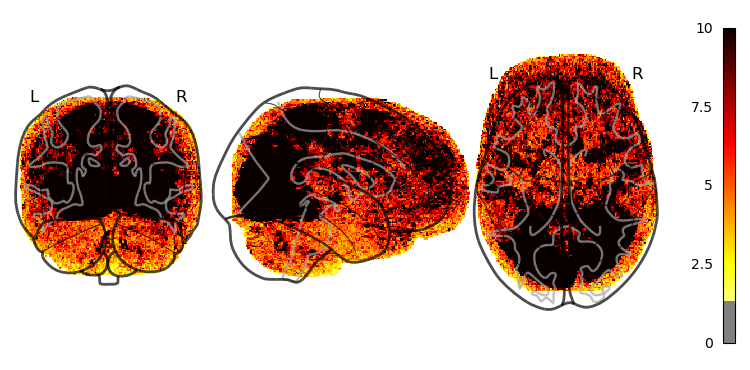

In [43]:
print(prf_dict['subj01']['nsd_dat'].keys())
prfbrain = NSP.utils.cap_values(prf_dict['subj01']['nsd_dat']['R2']['prf_ar'], 0, 100)
NSP.analyse.plot_brain(prf_dict, roi_masks, 'subj01', prfbrain, True)

In [12]:
y_dict['subj01']['V1_mask']['roi_sizes']

array([[95.     , 14.     , 84.     ,  0.23285],
       [64.     ,  6.     , 73.     ,  0.25482],
       [97.     , 13.     , 67.     ,  0.2561 ],
       [63.     ,  8.     , 78.     ,  0.32675],
       [58.     , 14.     , 61.     ,  0.21851],
       [97.     , 18.     , 84.     ,  0.28344],
       [99.     , 14.     , 82.     ,  0.40348],
       [60.     ,  9.     , 77.     ,  0.22923],
       [58.     , 13.     , 62.     ,  0.3546 ],
       [95.     , 15.     , 66.     ,  0.24714],
       [61.     , 11.     , 65.     ,  0.2034 ],
       [96.     , 14.     , 81.     ,  0.2916 ],
       [60.     ,  8.     , 78.     ,  0.25781],
       [64.     ,  8.     , 74.     ,  0.2436 ],
       [60.     ,  9.     , 79.     ,  0.246  ],
       [99.     , 15.     , 83.     ,  0.35771],
       [61.     ,  8.     , 71.     ,  0.23221],
       [63.     ,  8.     , 73.     ,  0.26268],
       [61.     ,  8.     , 80.     ,  0.28841],
       [61.     , 10.     , 77.     ,  0.25439],
       [61.     ,  7

##### Get a HRF signal dict across the visual cortex, with only some pRF parameter and R2 threshold restrictions

Voxels in V1 with a minimum R2 of 50 is approximately 5000
Found 4173 voxels in V1 with pRF sizes between 0.2 and 4
of which the average R2 value is 67.80887147136352

Voxels in V2 with a minimum R2 of 50 is approximately 3750
Found 3384 voxels in V2 with pRF sizes between 0.2 and 4
of which the average R2 value is 66.52408901891252

Voxels in V3 with a minimum R2 of 50 is approximately 3250
Found 3002 voxels in V3 with pRF sizes between 0.2 and 4
of which the average R2 value is 66.35720289806795

Voxels in V4 with a minimum R2 of 50 is approximately 2000
Found 1813 voxels in V4 with pRF sizes between 0.2 and 4
of which the average R2 value is 64.02594216216217



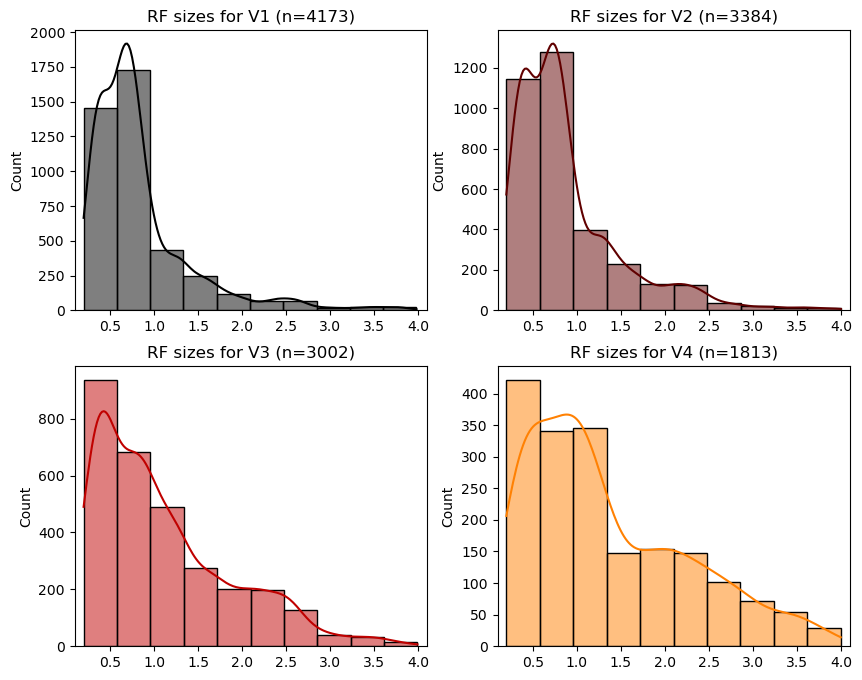

In [6]:
y_dict_all, xyz_to_vox_all = NSP.analyse.get_hrf_dict('subj01', voxels=roi_masks, prf_region = 'full_viscortex', 
                                             min_size = 0.2, max_size = 10, prf_proc_dict=prf_dict, max_voxels = None ,plot_sizes = 'y',
                                             vismask_dict=roi_masks, minimumR2=0, in_perc_signal_change=False)

##### Load y for single roi at a time:

In [7]:
y, xyzs = NSP.analyse.load_y(subject='subj01', 
                             roi='V1', 
                             hrf_dict=y_dict, 
                             xyz_to_name=xyz_to_vox, 
                             roi_masks=roi_masks, 
                             prf_dict=prf_dict, 
                             n_voxels='all', 
                             start_img=0, 
                             n_imgs=30000,
                             verbose=True,
                             across_rois=False)

Loaded y-matrix with 98 voxels from ['V1']


##### Load y across early visual cortex:

In [ ]:
y_all, xyzs_all = NSP.analyse.load_y(subject='subj01', 
                             roi=None, 
                             hrf_dict=y_dict_all, 
                             xyz_to_name=xyz_to_vox_all, 
                             roi_masks=roi_masks, 
                             prf_dict=prf_dict, 
                             n_voxels=100, 
                             start_img=0, 
                             n_imgs=3750, # Only extracted betas across visual cortex for the first 5 sessions 
                             verbose=True,
                             across_rois=True)

##### Inspect the pRFs in your y-matrix

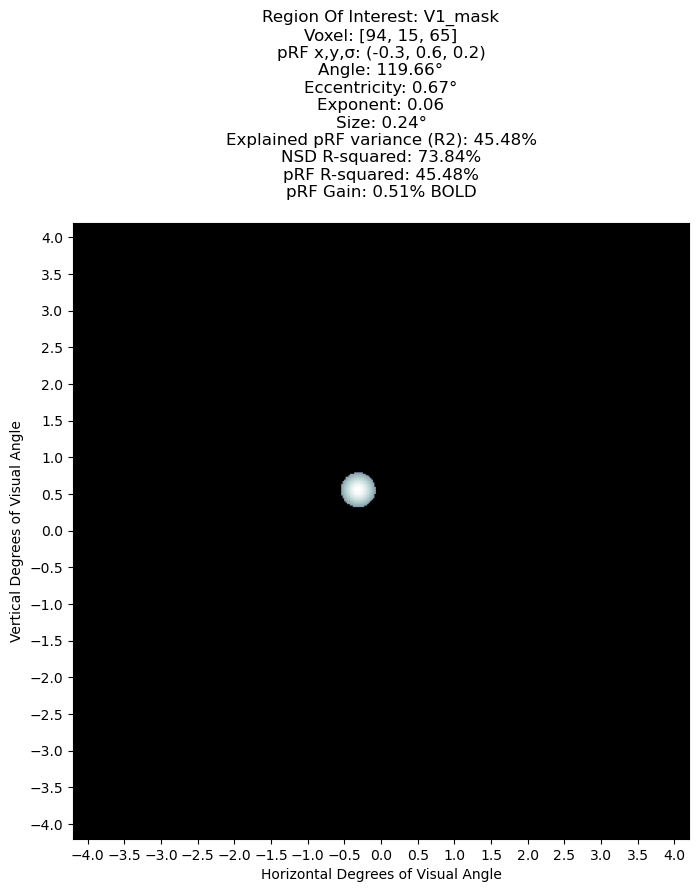

In [7]:
which_voxel = random.randint(0, xyzs.shape[0])
NSP.cortex.plot_top_vox(dim=425, 
                        type='cut_gaussian',
                        subject='subj01',
                        vismask_dict=roi_masks,
                        prf_dict=prf_dict,
                        xyz_only=xyzs[which_voxel][0])

##### Load in one of the baseline features (Root Mean Square, Spatial Coherence, Contrast Energy)

In [6]:
Xrms = NSP.stimuli.baseline_feats('rms')
Xce = NSP.stimuli.baseline_feats('ce')
Xsc = NSP.stimuli.baseline_feats('sc_l')

##### Load in a selection of the loss metrics from the U-Net, the Unpredictability features

['content_loss_0_MSE', 'content_loss_1_MSE', 'content_loss_2_MSE', 'content_loss_3_MSE', 'content_loss_4_MSE', 'ssim']


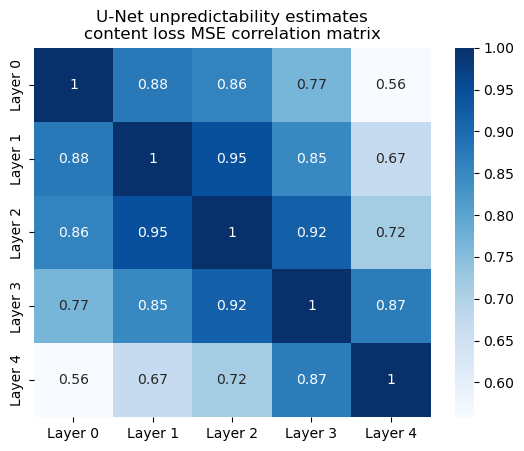

In [92]:
Xpred = NSP.stimuli.unpred_feats(content=True, style=False, ssim=True, pixel_loss=False, L1=False, MSE=True, verbose=True)
# Inspect the correlation matrix for a specific set of the loss metrics
NSP.stimuli.unpred_corrmatrix(type='content', loss_calc='MSE', cmap='Blues')

##### Plot a similar correlation matrix, but for also add the baseline contrast features

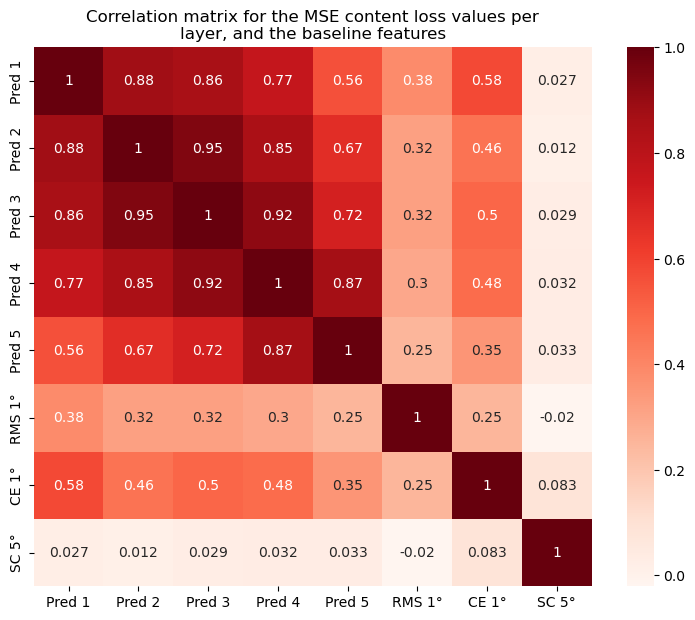

In [93]:
NSP.stimuli.plot_correlation_matrix(include_rms=True, include_ce=True, include_ce_l=False, include_sc=False, include_sc_l=True, cmap='Reds')

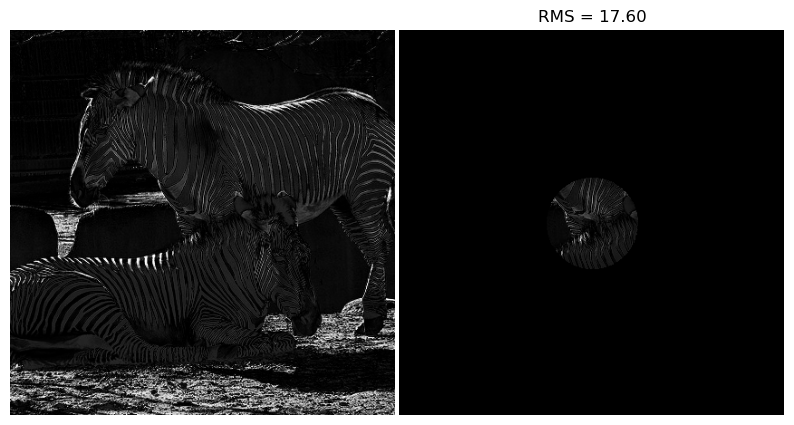

In [86]:
# This is when using the L parameter of the LAB colour space, which is the luminance channel. Best to use.
# Check to see whether my function actually exclusively calculates the RMS of the patch. It does.
from funcs.imgproc import get_rms_contrast_lab

# Choose image from the natural scenes dataset
# img_no = 46002 #29
img_no = NSP.stimuli.imgs_designmx()['subj01'][5]

scalefactor = 8.4

binmask = NSP.utils.make_circle_mask(425, 213, 213, 425/scalefactor)

img = NSP.stimuli.show_stim(img_no=img_no, hide=True)[0]

wmask = NSP.utils.css_gaussian_cut(425, 213, 213, (425/scalefactor)).reshape((425,425))

# tiny = get_rms_contrast_lab(img, NSP.utils.css_gaussian_cut(425, 213, 213, (425/16.8)), binmask, normalise = True, plot = 'y')
small = NSP.stimuli.get_rms_contrast_lab(img, wmask, binmask, normalise = True, plot = True)
# small = NSP.stimuli.get_rms_contrast_lab(img, NSP.utils.css_gaussian_cut(425, 213, 213, (425/scalefactor)), binmask, normalise = True, plot = True)

# big = get_rms_contrast_lab(img, NSP.utils.css_gaussian_cut(425, 213, 213, (425/4.2)), binmask, normalise = True, plot = 'y')

In [ ]:
    # Plot a correlation matrix for specific loss value estimations of unpredictability estimates
    def features_corrmatrix(subject='subj01', type:str='content', loss_calc:str='MSE', cmap:str='copper_r'):

                
        predfeatnames = [name for name in list(self.features()['all_predestims.h5'].keys()) if name.endswith(loss_calc) and name.startswith(type)]

        # Build dataframe
        data = {name: self.features()['all_predestims.h5'][name] for name in predfeatnames}
        df = pd.DataFrame(data)

        # Compute correlation matrix
        corr_matrix = df.corr()
        ticks = [f'Layer {name.split("_")[2]}' for name in predfeatnames]
        sns.heatmap(corr_matrix, annot=True, cmap=cmap, xticklabels=ticks, yticklabels=ticks)
        plt.title(f'U-Net unpredictability estimates\n{type} loss {loss_calc} correlation matrix')
        plt.show()

##### Load in a selection of the AlexNet feature maps extracted from the adjusted U-Net class

In [4]:
Xalex_unet = NSP.stimuli.unet_featmaps([2, 3])

##### Inspect the feature maps extracted from UNet

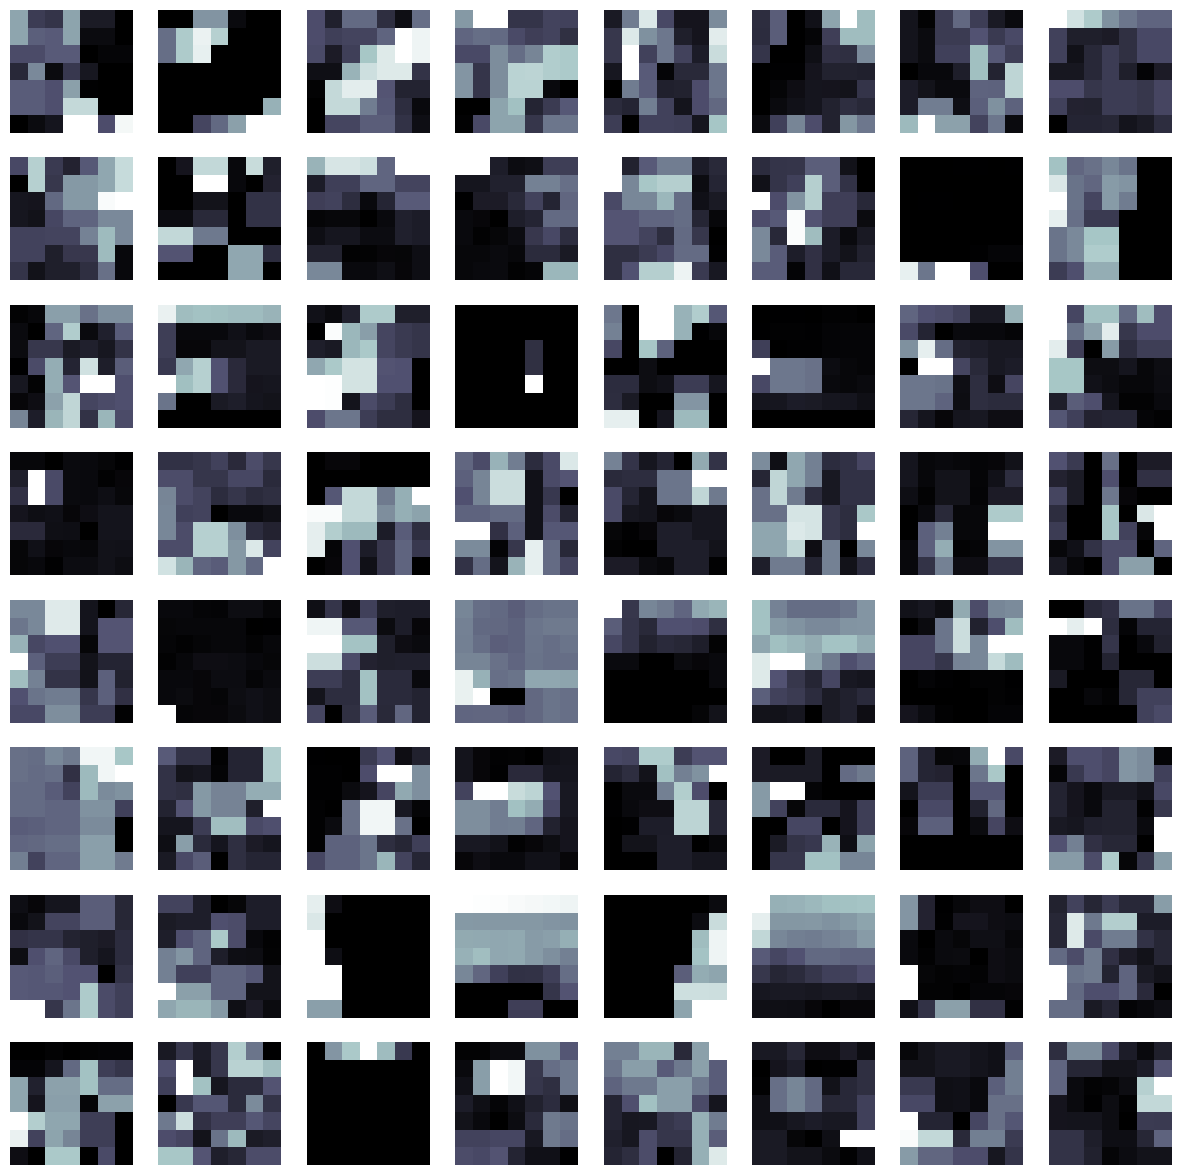

In [6]:
NSP.stimuli.plot_unet_feats(layer=0, batch=3, cmap='bone', subject='subj01')

##### Extracted features from my own alexnet implementation

In [132]:
layer_nos = [4, 7, 9, 11] # Which layers to take the extracted feature maps from
Xalex_own = NSP.stimuli.alex_featmaps(layer_nos, pcs_per_layer='all', subject='subj01')

##### Some visual checks of these features

In [14]:
# Be aware that the layer number here is 1 more than the ones of the 'alex_layn.npy' files, because there I do not include the input layer
# so alex_lay0 corresponds with layer1 here.
img_ids, dataset, pca, feature, lay, layname = NSP.stimuli.extract_features(subject='subj01', layer=12,
                                                     start_img=8, n_imgs=2, batch_size=2, pca_components=2,
                                                     verbose=True, img_crop=True)

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['input', 'Conv2d_1', 'ReLU_1', 'MaxPool2d_1', 'Conv2d_2', 'ReLU_2', 'MaxPool2d_2', 'Conv2d_3', 'ReLU_3', 'Conv2d_4', 'ReLU_4', 'Conv2d_5', 'ReLU_5', 'MaxPool2d_3', 'Dropout_1', 'Linear_1', 'ReLU_6', 'Dropout_2', 'Linear_2', 'ReLU_7', 'Linear_3']
['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


### Turn this into functions

In [78]:
# The ReLU layers of the alexnet are at layerfeatures 1, 4, 7, 9, and 11
# Here we stack all those for the ultimate regression, vary the top_n principal components of these layers
layer_nos = [1, 4, 7, 9, 11]
X_all = []
for layer in layer_nos:
    this_X = np.load(f'/home/rfpred/data/custom_files/subj01/center_strict/alex_lay{layer}.npy')[:,:500]
    if layer == 1:
        X_all = this_X
    else: X_all = np.hstack((X_all, this_X))
    
    
# Columns are the n amount of prinicple components multiplied by the amount of layers, so for example 100 * 5 = 500
print(X_all.shape)
X = X_all

(30000, 2500)


[[1.      0.14087 0.00995 0.10226 0.08899]
 [0.14087 1.      0.01339 0.19475 0.16991]
 [0.00995 0.01339 1.      0.01356 0.00683]
 [0.10226 0.19475 0.01356 1.      0.1921 ]
 [0.08899 0.16991 0.00683 0.1921  1.     ]]


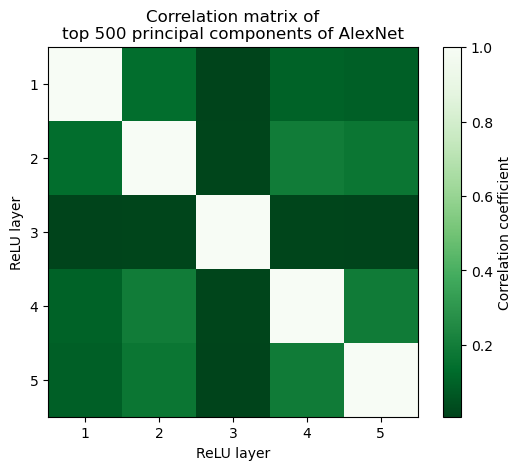

In [52]:
# Correlation matrix for the 5 AlexNet layers
# Split X_all into separate arrays for each layer
X_split = np.hsplit(X_all, len(layer_nos)) # Amazing function, splits the array into n arrays along the columns

# Initialize an empty matrix for the correlations
corr_matrix = np.empty((len(layer_nos), len(layer_nos)))

# Calculate the correlation between each pair of layers
for i in range(len(layer_nos)):
    for j in range(len(layer_nos)):
        corr_matrix[i, j] = np.corrcoef(X_split[i].flatten(), X_split[j].flatten())[0, 1]

print(corr_matrix)

# Create a heatmap from the correlation matrix
plt.imshow(corr_matrix, cmap='Greens_r', interpolation='nearest')
plt.colorbar(label='Correlation coefficient')

relu_nos = [no for no in range(1,6)]
# Set the tick labels
plt.xticks(np.arange(len(layer_nos)), relu_nos)
plt.yticks(np.arange(len(layer_nos)), relu_nos)

# Set the title and labels
plt.title('Correlation matrix of\ntop 500 principal components of AlexNet')
plt.xlabel('ReLU layer')
plt.ylabel('ReLU layer')

plt.show()

### Now I have these R2 values (the cv scores), I should also fetch the R2 values of these voxels. Should be doable by combining some existing functions, and extracting the vox xyz or name (probably name) from one of the functions already being used. 

Loaded y-matrix with 392 voxels from ['V1', 'V2', 'V3', 'V4']


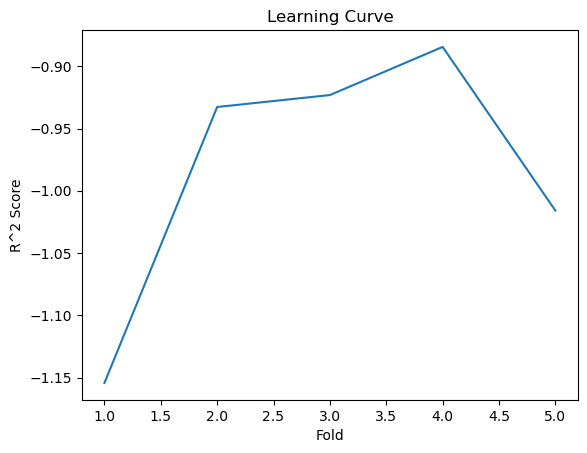

In [47]:
y, xyzs = NSP.analyse.load_y('subj01', 'V1', y_dict, xyz_to_vox, roi_masks, prf_dict, n_voxels = 'all', start_img = 0, n_imgs = 3750, across_rois=True)
Xalex_unet = NSP.stimuli.unet_featmaps([3])
n_imgs = 3750
X = Xalex_unet
alf = .01
cv = 5
results = NSP.analyse.evaluate_model(X[:n_imgs,:], y[:n_imgs], alpha=alf, cv=cv)
# results['predicted_values']

_ = NSP.analyse.plot_learning_curve(X[:n_imgs,:], y[:n_imgs], model=results['model'], alpha=alf, cv=cv)
# NSP.analyse.plot_feature_importance(X, y, model=results['model'], alpha=.1)
# NSP.analyse.plot_residuals(X, y, model=results['model'], alpha=alf)

/tmp/ipykernel_2933608/395035713.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv_r2[vox, 3] = cv_r2_stack[vox] * 100


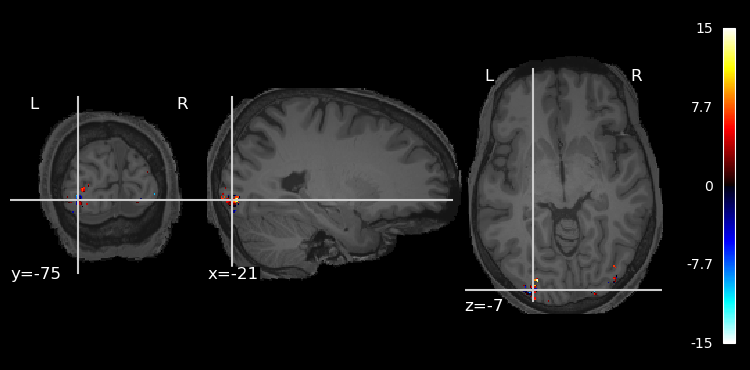

In [120]:
# Get the reg results in an array with the corresponding voxels to plot
n_voxels = xyzs_stack.shape[0]
cv_r2 = np.zeros((n_voxels, 4))
for vox in range(n_voxels):
    cv_r2[vox, :3] = (xyzs_stack[vox][0][0], xyzs_stack[vox][0][1], xyzs_stack[vox][0][2])
    # cv_r2[vox, 3] = results['cross_validation_scores'][vox]
    cv_r2[vox, 3] = cv_r2_stack[vox] * 100
    
cv_r2_brainp = NSP.utils.coords2numpy(cv_r2, roi_masks['subj01']['V1_mask'].shape, keep_vals=True)

cv_r2_nii = nib.Nifti1Image(cv_r2_brainp, NSP.cortex.anat_templates(prf_dict)['subj01'].affine)


plotting.plot_stat_map(cv_r2_nii, bg_img=NSP.cortex.anat_templates(prf_dict)['subj01'], display_mode='ortho', colorbar=True)


In [11]:
R2_dict = NSP.cortex.nsd_R2_dict(roi_masks, glm_type='hrf')
prf_rsq_dict = NSP.cortex.rsquare_selection(prf_dict, 1000, n_subjects=8, dataset='prf')
nsd_rsq_dict = NSP.cortex.rsquare_selection(R2_dict, 10000, n_subjects=8, dataset='nsd')

In [125]:
NSP.utils.find_common_rows(nsd_rsq_dict['subj01']['V1_mask'], cv_r2, keep_vals=True)

array([[95.     , 14.     , 84.     , 63.14764],
       [64.     ,  6.     , 73.     , 53.55065],
       [97.     , 13.     , 67.     , 61.04699],
       [63.     ,  8.     , 78.     , 75.67644],
       [58.     , 14.     , 61.     , 51.17767],
       [97.     , 18.     , 84.     , 59.41842],
       [99.     , 14.     , 82.     , 58.97344],
       [60.     ,  9.     , 77.     , 67.9286 ],
       [58.     , 13.     , 62.     , 47.77798],
       [95.     , 15.     , 66.     , 72.16811],
       [61.     , 11.     , 65.     , 51.27472],
       [96.     , 14.     , 81.     , 65.11759],
       [60.     ,  8.     , 78.     , 74.7804 ],
       [64.     ,  8.     , 74.     , 70.48401],
       [60.     ,  9.     , 79.     , 76.26929],
       [99.     , 15.     , 83.     , 63.5265 ],
       [61.     ,  8.     , 71.     , 49.83541],
       [63.     ,  8.     , 73.     , 65.26459],
       [61.     ,  8.     , 80.     , 64.14439],
       [61.     , 10.     , 77.     , 66.47135],
       [61.     ,  7

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


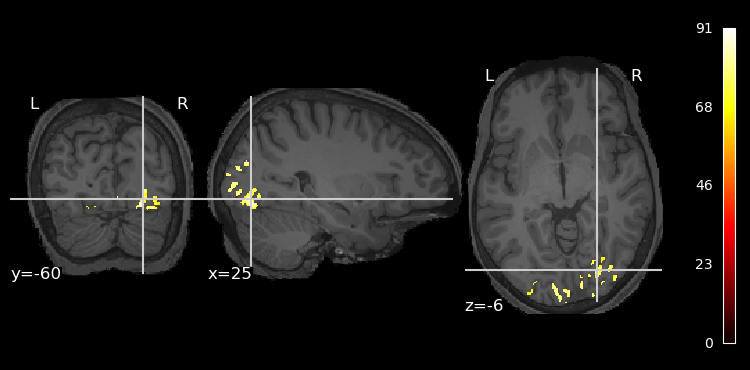

In [88]:

for i in range(1,5):
    if i == 1:
        roi_stack = nsd_rsq_dict['subj01'][f'V{i}_mask']
    else:
        roi_stack = np.vstack((roi_stack, nsd_rsq_dict['subj01'][f'V{i}_mask']))

roi_stack_brain = NSP.utils.coords2numpy(roi_stack, roi_masks['subj01']['V1_mask'].shape, keep_vals=True)

roi_stack_nii = nib.Nifti1Image(roi_stack_brain, NSP.cortex.anat_templates(prf_dict)['subj01'].affine)


plotting.plot_stat_map(roi_stack_nii, bg_img=NSP.cortex.anat_templates(prf_dict)['subj01'], display_mode='ortho', colorbar=True)


##### Get the y matrices for whole rois

## This is now outdated, I've outperforemed

In [143]:
betapath = 'data/custom_files/subj01hrf_dict.pkl'
with open(betapath, 'rb') as f:
    betas = pickle.load(f)
    
betas['subj01']['V1_mask']['voxel1']

{'xyz': [56, 9, 74],
 'size': 0.28145,
 'hrf_betas': array([-0.00333, -0.96   , -1.20333, ..., -0.82667,  0.66667, -0.51333]),
 'hrf_betas_z': 0,
 'hrf_rsquared': 0,
 'hrf_rsquared_z': 0}

In [144]:
y, xyzs = NSP.analyse.load_y('subj01', 'V1', y_dict, xyz_to_vox, roi_masks, prf_dict, n_voxels = 'all', start_img = 0, n_imgs = 30000, across_rois=False)

Loaded y-matrix with 98 voxels from ['V1']


In [122]:
y, xyzs = NSP.analyse.load_y('subj01', 'V1', y_dict, xyz_to_vox, roi_masks, prf_dict, n_voxels = 'all', start_img = 0, n_imgs = 30000, across_rois=True)

Loaded y-matrix with 392 voxels from ['V1', 'V2', 'V3', 'V4']


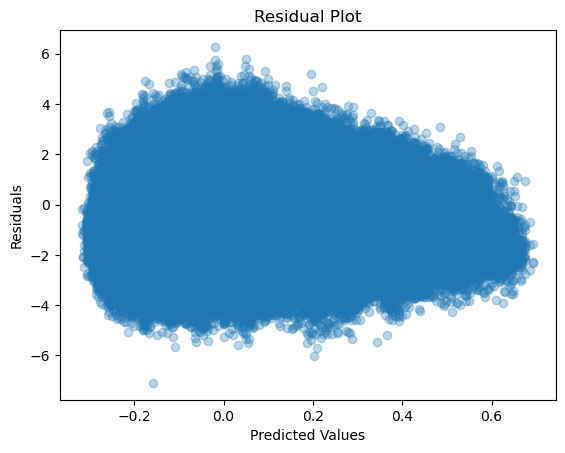

In [139]:
NSP.analyse.plot_residuals(Xrms, y)

In [107]:
V1y = NSP.datafetch._stack_betas('subj01', 'V1', True, 40)[:,3:].T
V2y = NSP.datafetch._stack_betas('subj01', 'V2', True, 40)[:,3:].T
V3y = NSP.datafetch._stack_betas('subj01', 'V3', True, 40)[:,3:].T
V4y = NSP.datafetch._stack_betas('subj01', 'V4', True, 40)[:,3:].T

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

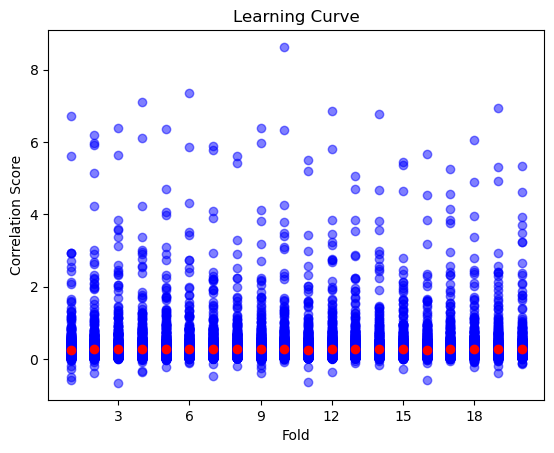

In [121]:
# y, xyzs = NSP.analyse.load_y('subj01', 'V1', y_dict, xyz_to_vox, roi_masks, prf_dict, n_voxels = 100, start_img = 0, n_imgs = 3750, across_rois=True)
# y = NSP.datafetch._stack_betas('subj01', 'V2', True, 40)[:,3:].T
y = V1yselect.T
# plt.plot(y)
Xrms = NSP.stimuli.baseline_feats('rms')
# Xce = NSP.stimuli.baseline_feats('ce')
# Xsc_l = NSP.stimuli.baseline_feats('sc_l')
Xalex_unet = NSP.stimuli.unet_featmaps([3])

# X = np.ones((Xce.shape))
# X = NSP.stimuli.baseline_feats('ce_l')
X = Xalex_unet
model = NSP.analyse.run_ridge_regression(X, y, alpha=1)
betas = model.coef_ # This returns a beta coefficient for every voxel
# y_hats, cor_scores = NSP.analyse.score_model(Xpred, y, model, cv=5)
NSP.analyse.plot_learning_curve(X, y, model, 1, 20)


# cor_scores is a list with the voxel correlation scores for each cross-validation fold

### Do'nt forget to scale the betas, z00000scoror

In [105]:
y.shape

(30000, 8296)

#### Also check for irrelevant RMS values, beacuse it seems now as if anything yields nice results. Adapt the NSP.features.baseline thign to also 
#### include the irrelevant rms vlues.

In [97]:
# Took 2m 48s
for roi in rois:
    Xrms = NSP.stimuli.baseline_feats('rms')
    X = X_all
    betas = NSP.datafetch._stack_betas('subj01', roi, True, 40)
    y = betas[:,3:].T
    model = NSP.analyse.run_ridge_regression(X, y, alpha=.01)


    xyztest =(betas[:, :3])
             
    y_hats, cor_scores = NSP.analyse.score_model(X, y, model, cv=20)

    cor_means = np.mean(np.array(cor_scores), axis=0)
    if roi == 'V1':
        xyztest_stack = xyztest
        cor_means_stack = cor_means
    else: 
        xyztest_stack = np.vstack((xyztest_stack, xyztest))         
        cor_means_stack = np.hstack((cor_means_stack, cor_means))

brainresults = np.hstack((xyztest_stack, cor_means_stack.reshape(-1,1)))
np.save('/home/rfpred/data/custom_files/subj01/brainstats/ce_viscortex.npy', brainresults)

NSP.analyse.plot_learning_curve(X, y, model, 1.0, 20)

# NSP.analyse.stat_on_brain(prf_dict, roi_masks, 'subj01', cor_means, xyzs, True)


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

NameError: name 'cv' is not defined

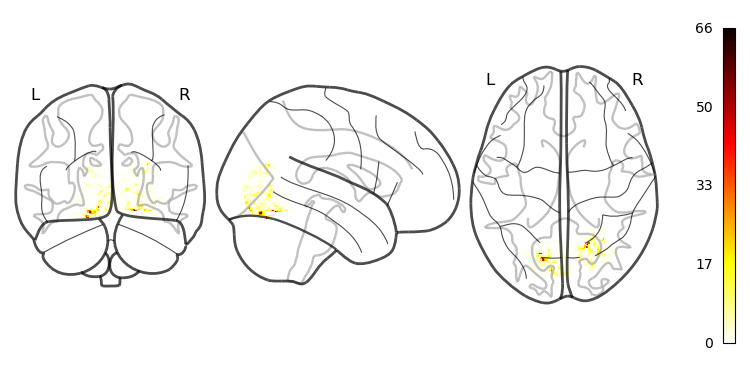

In [16]:
NSP.analyse.stat_on_brain(prf_dict, roi_masks, 'subj01', cor_means_stack, xyztest_stack, True)
# Xpred_results_brain = NSP.utils.coords2numpy(Xpred_results, roi_masks['subj01']['V1_mask'].shape, keep_vals=True)
# NSP.analyse.plot_brain(prf_dict, roi_masks, 'subj01', Xpred_results_brain, True)

Lowest value: -0.1852293430558951
Highest value: 63.48897093496528
Mean value: 0.44784907224832127
Standard deviation: 1.6281024405129818
There are 36 of these voxels


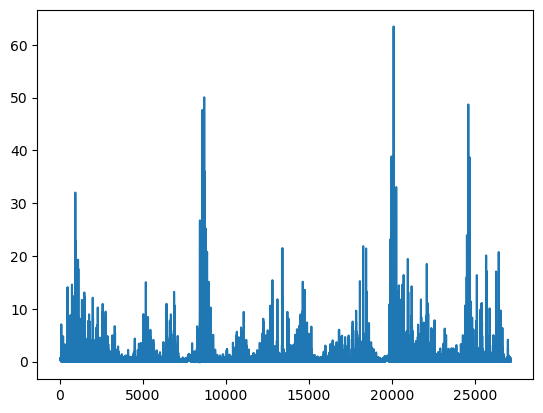

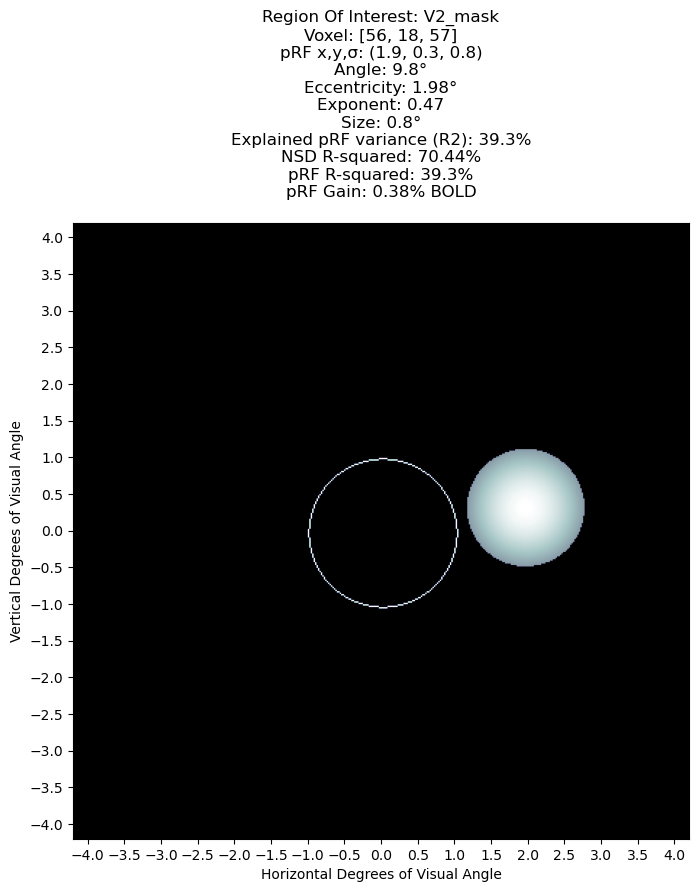

In [98]:
# DEfinitely turn this into a function, also couple with the heatmap stuff (ONCE MADE EFFICIENT). 
# Based on the highest correlation values resulting from the ridge reg, I can then plot the voxels that yield
# THe highest correlation values between y and yhat, as a sort of 'decoding validation'. Potentially very cool as an
# extra check to validate that certain visual features explain the activity best of the voxels with their pRFs inside the
# patch for which we calculated it. 
NSP.utils.inspect_dat(cor_means_stack)
plt.plot(cor_means_stack)
ices = cor_means_stack > 20
goodxyzs = xyztest_stack[ices]
print(f'There are {goodxyzs.shape[0]} of these voxels')

which_voxel = random.randint(0, goodxyzs.shape[0])
NSP.cortex.plot_top_vox(dim=425, 
                        type='cut_gaussian',
                        add_central_patch=True,
                        subject='subj01',
                        vismask_dict=roi_masks,
                        prf_dict=prf_dict,
                        xyz_only=tuple(goodxyzs[which_voxel].astype(int)))

Lowest value: -0.2281478432195704
Highest value: 64.54057606785801
Mean value: 0.4493600181176349
Standard deviation: 1.6362796812565403
There are 132 of these voxels


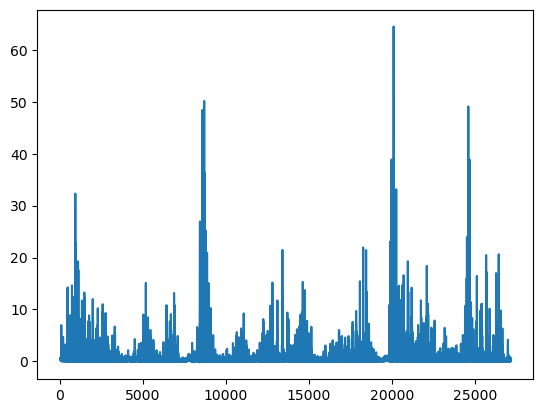

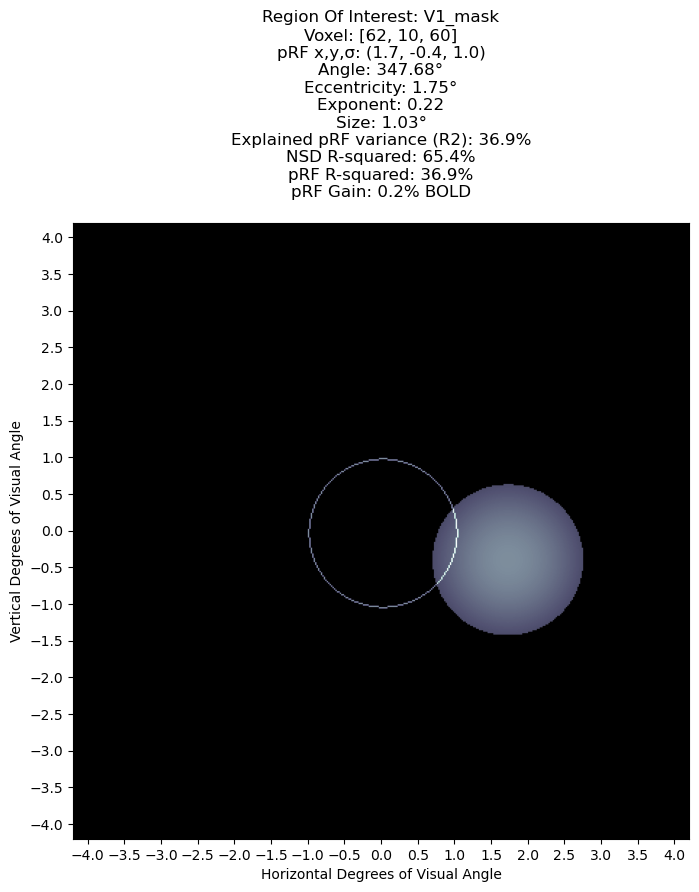

In [76]:
# DEfinitely turn this into a function, also couple with the heatmap stuff (ONCE MADE EFFICIENT). 
# Based on the highest correlation values resulting from the ridge reg, I can then plot the voxels that yield
# THe highest correlation values between y and yhat, as a sort of 'decoding validation'. Potentially very cool as an
# extra check to validate that certain visual features explain the activity best of the voxels with their pRFs inside the
# patch for which we calculated it. 
NSP.utils.inspect_dat(cor_means_stack)
plt.plot(cor_means_stack)
ices = cor_means_stack > 10
goodxyzs = xyztest_stack[ices]
print(f'There are {goodxyzs.shape[0]} of these voxels')

which_voxel = random.randint(0, goodxyzs.shape[0]-1)
NSP.cortex.plot_top_vox(dim=425, 
                        type='cut_gaussian',
                        add_central_patch=True,
                        subject='subj01',
                        vismask_dict=roi_masks,
                        prf_dict=prf_dict,
                        xyz_only=tuple(goodxyzs[which_voxel].astype(int)))

In [37]:
y, xyzs = NSP.analyse.load_y('subj01', 'V2', y_dict, xyz_to_vox, roi_masks, prf_dict, n_voxels = 'all', start_img = 0, n_imgs = 30000)

n_imgs = 100
X = Xce
alf = .01
cv = 15
results = NSP.analyse.evaluate_model(X[:n_imgs,:], y[:n_imgs], alpha=alf, cv=cv)

# Create a new numpy array with 4 columns
data = np.zeros((len(xyzs[:,0]), 4))

# Fill the first 3 columns with the xyz values
for i, coord in enumerate(xyzs[:,0]):
    data[i, :3] = coord

# Fill the fourth column with the cross-validation scores
data[:, 3] = results['cross_validation_scores']

NSP.analyse.plot_learning_curve(X[:n_imgs,:], y[:n_imgs], model=results['model'], alpha=alf, cv=cv)
results

print(data)

Loaded y-matrix with 165 voxels from ['V2']


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

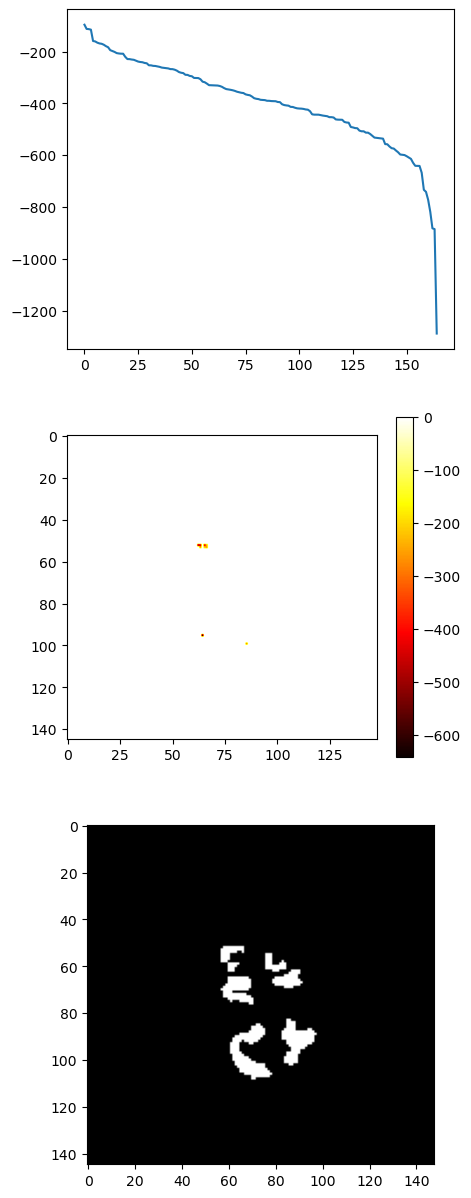

In [268]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define a diverging colormap where the 0 value is black
# colors = ["blue", "white", "red"]
# cmap = mcolors.LinearSegmentedColormap.from_list("", colors)
# n_voxels = y_all.shape[1]
n_voxels = y.shape[1]

cv_r2_all = np.zeros((n_voxels, 4))
# for vox in range(len(results['cross_validation_scores'])):
for vox in range(n_voxels):
    for idx in range(3):
        # cv_r2_all[vox,idx] = xyzs_all[vox][0][idx]
        cv_r2_all[vox,idx] = xyzs[vox][0][idx]
    cv_r2_all[vox,3] = results['cross_validation_scores'][vox]




brain = NSP.utils.coords2numpy(cv_r2_all, shape=roi_masks['subj01']['V1_mask'].shape, keep_vals=True)

fig,axes = plt.subplots(3,figsize=(5,15))


cv_sorted = NSP.utils.sort_by_column(cv_r2_all, 3, top_n=n_voxels)
axes[0].plot(cv_sorted[:,3]*100)#[:,3].flatten

# Normalize the data to the range [-0.1, 0.1]
# norm = mcolors.Normalize(vmin=-0.002, vmax=0.002)

# Display the image with the custom colormap and normalization
im = axes[1].imshow(brain[:,16,:]*100, cmap='hot')
axes[2].imshow(roi_masks['subj01']['V2_mask'][:,16,:], cmap='gray')
# Add a colorbar
plt.colorbar(im)

plt.show()


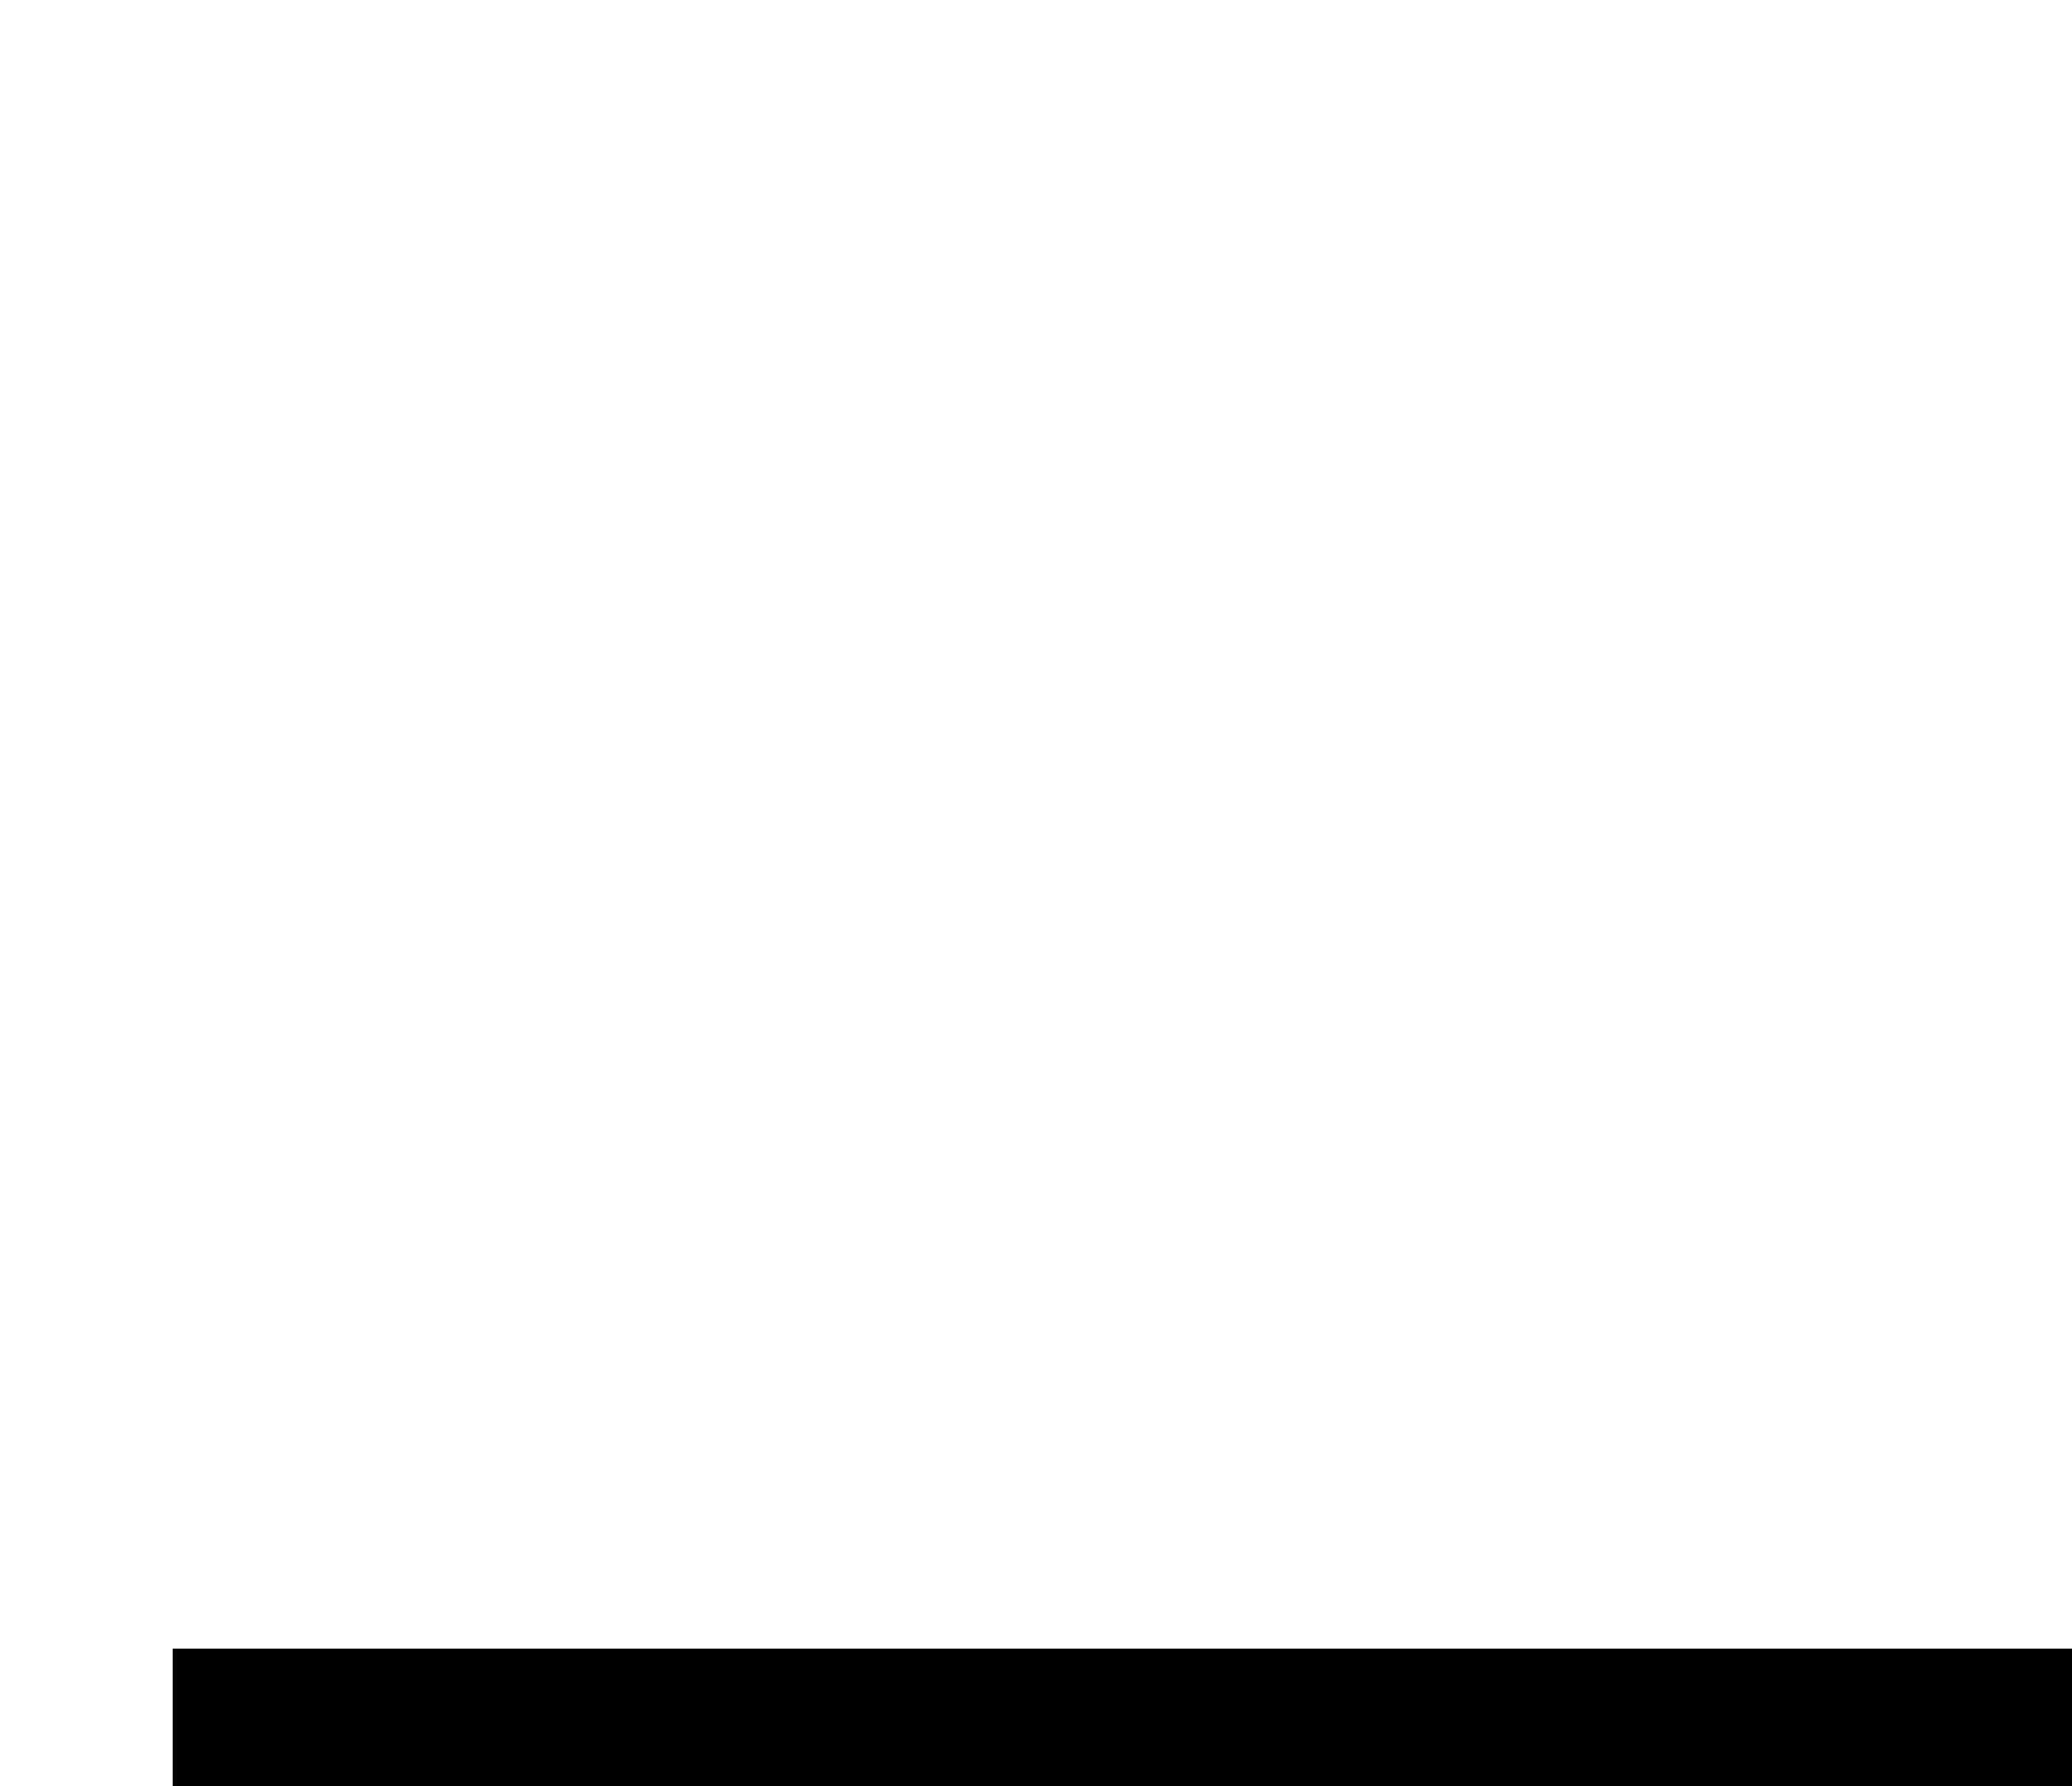
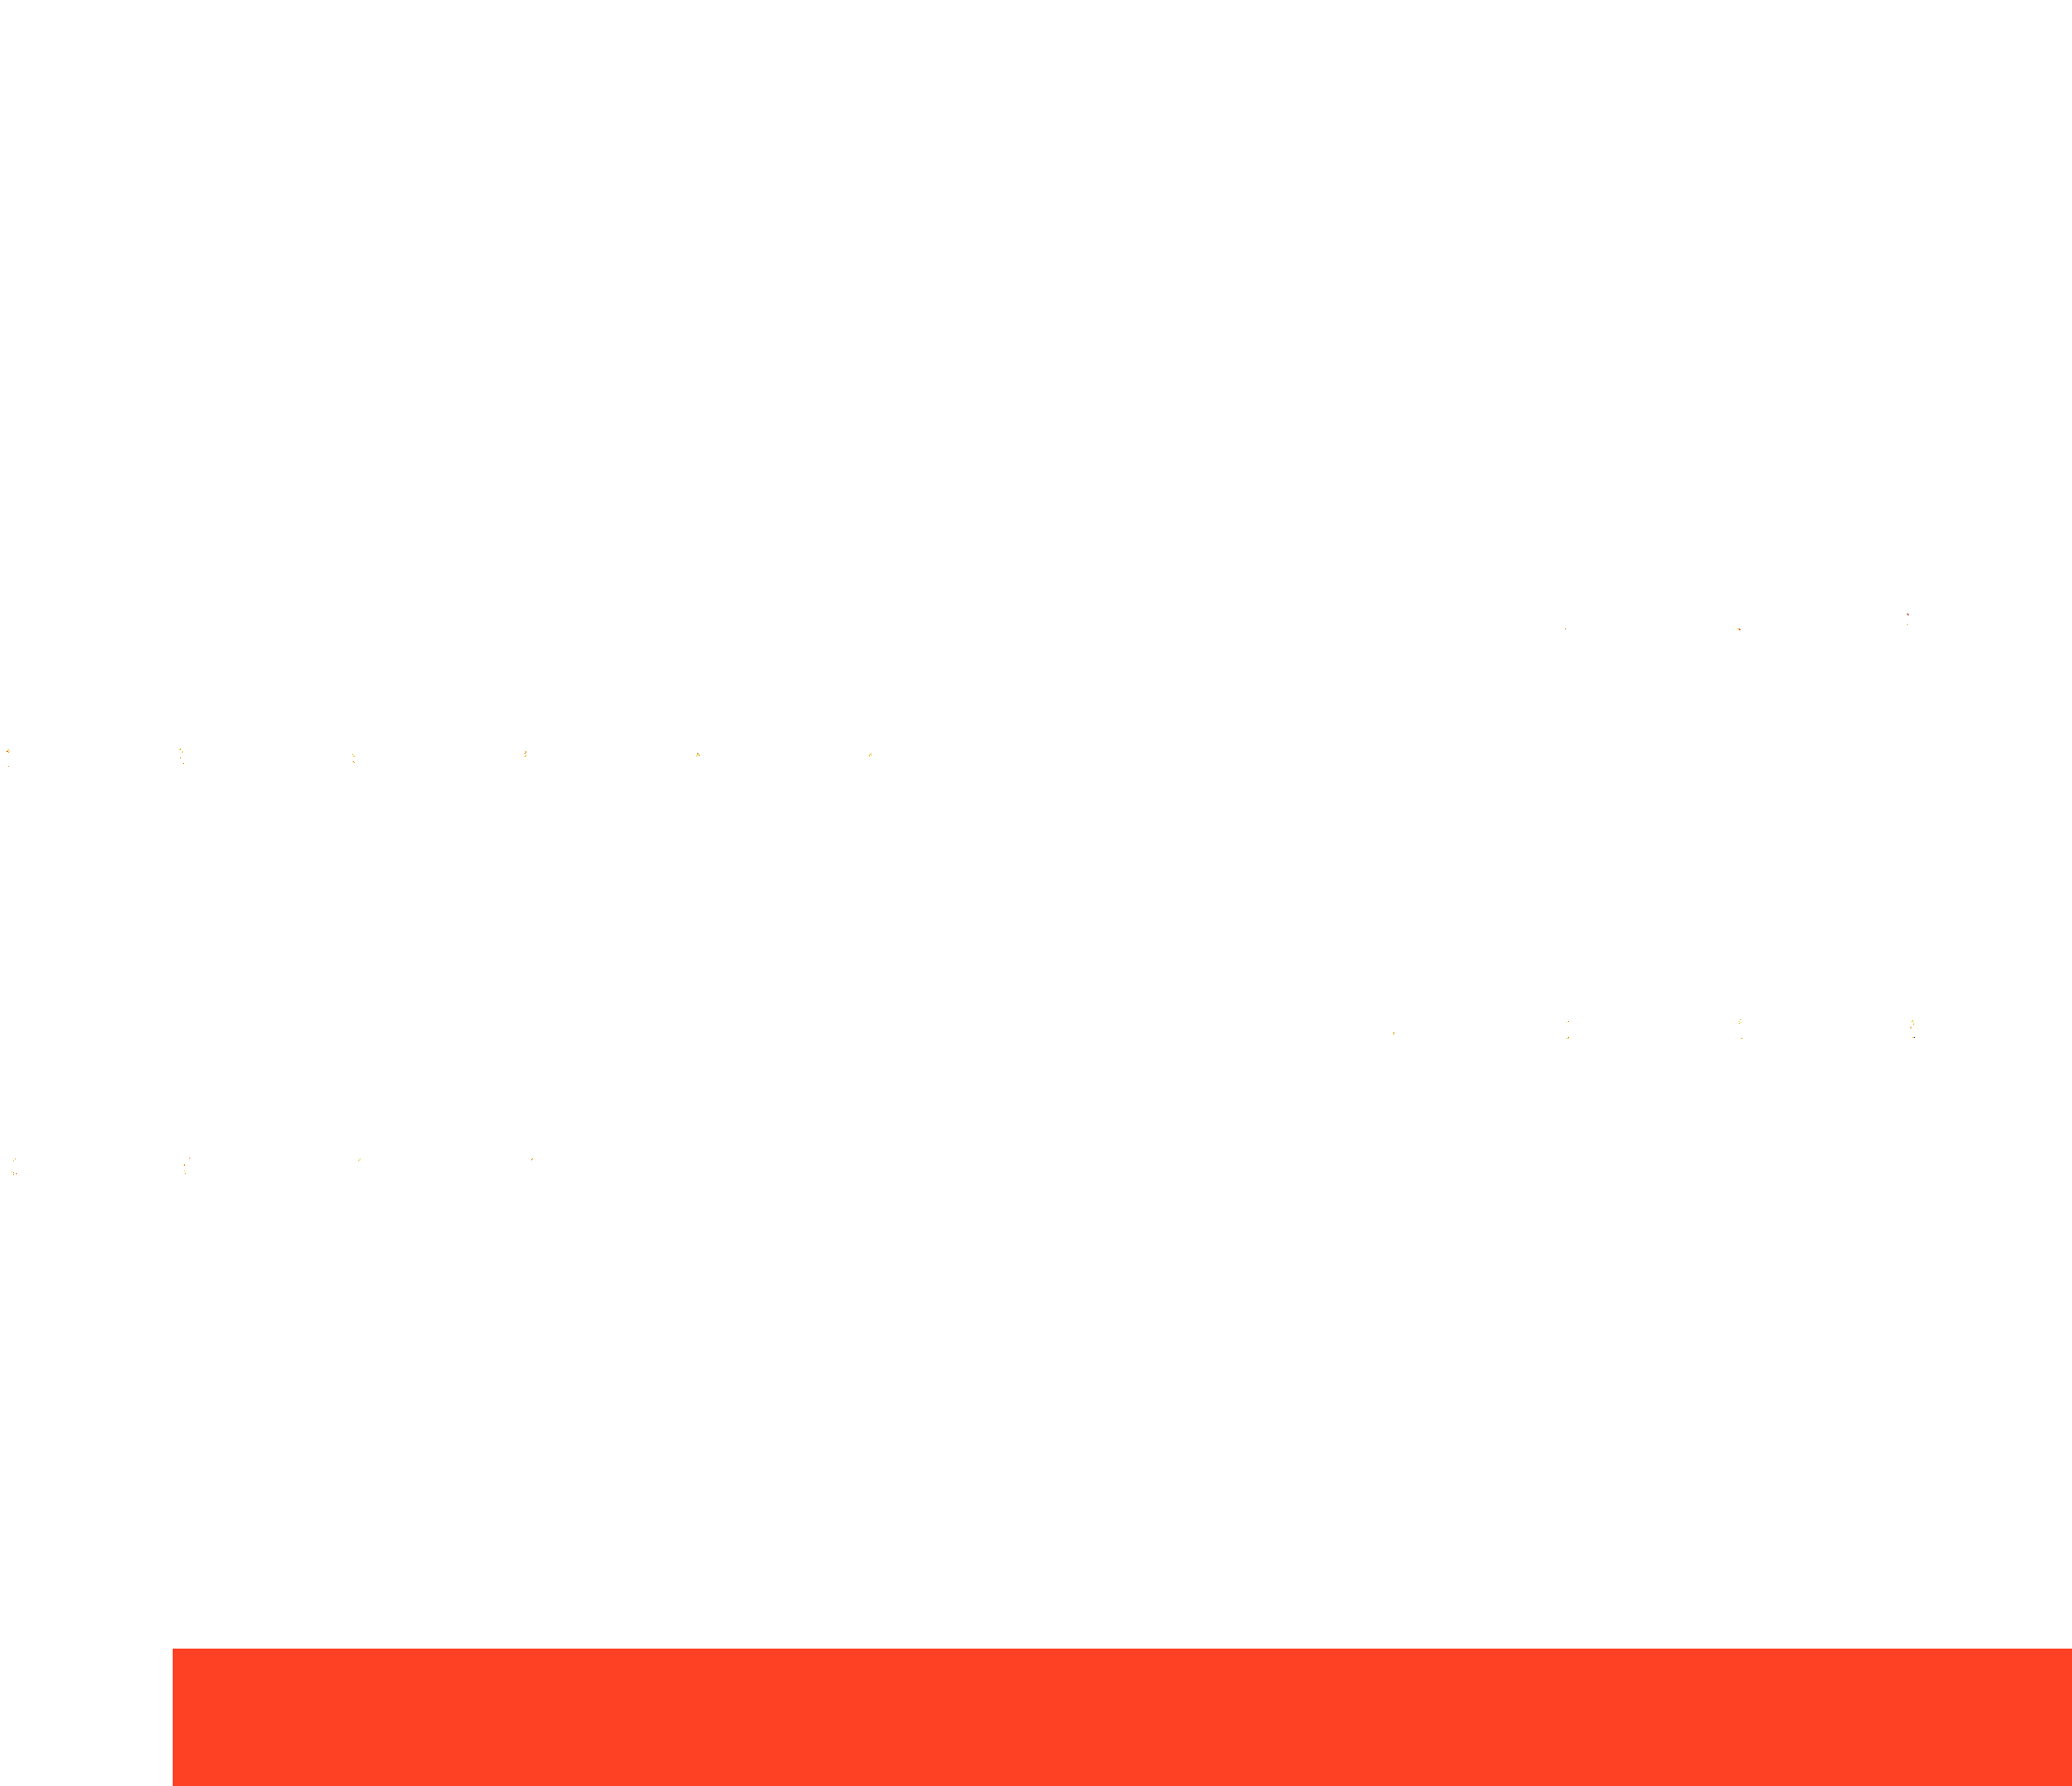

In [59]:
from scipy.special import softmax
anat_sub1_np = NSP.cortex.anat_templates(prf_dict)['subj01'].get_fdata()
# print(anat_maps['subj01'].shape)

anat_sub1_coords = NSP.utils.numpy2coords(anat_sub1_np, keep_vals = True)

anat_sub1_coords[:,3] = softmax(anat_sub1_coords[:,3])

anat_sub1_sm = NSP.utils.coords2numpy(anat_sub1_coords, shape = NSP.cortex.anat_templates(prf_dict)['subj01'].shape, keep_vals = True)

# Convert numpy array back to nibabel image
anat_sub1_sm_nii = nib.Nifti1Image(brain*100, NSP.cortex.anat_templates(prf_dict)['subj01'].affine)

# Now you can use this nibabel image with nilearn's plotting function
# plotting.view_img(anat_sub1_sm_nii, bg_img=None, cmap='binary', symmetric_cmap=False)
plotting.view_img(anat_sub1_sm_nii, bg_img=None, cmap='CMRmap', symmetric_cmap=True)

# plotting.view_img(anat_sub1_sm, bg_img=None, cmap='binary', symmetric_cmap=False)


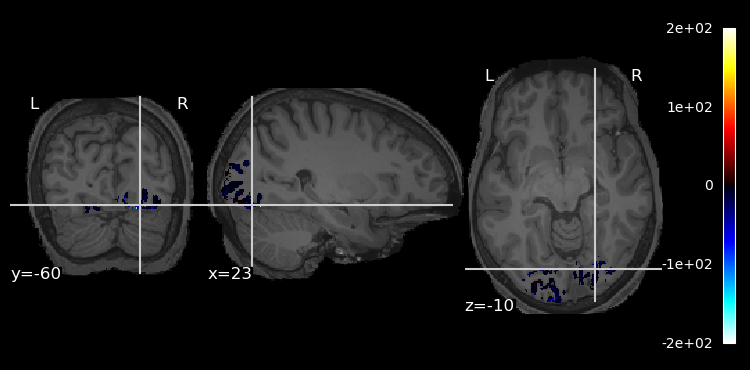

In [208]:
plotting.plot_stat_map(anat_sub1_sm_nii, bg_img=NSP.cortex.anat_templates(prf_dict)['subj01'], display_mode='ortho', colorbar=True)

In [ ]:
# This function creates a numpy array that I can use to transform into a plottable numpy array in the shape of the subjects brain.
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from nilearn import plotting, image
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap


def visualise_betas(hrf_dict = None, subject = 'subj01', n_trials = 10, which_roi = 'V1', n_voxels = 'all', z_voxel:bool = True):
    if which_roi == 'all':
        rois = hrf_dict[subject].keys()
    else: 
        rois = [f'{which_roi}_mask']
    
    for roi in rois:
        if n_voxels == 'all':
            n_voxels = len(hrf_dict[subject][roi])
            
        voxbetas = np.zeros((n_voxels, n_trials + 3))    
        print(voxbetas.shape)
        # Initialize lists to store voxel coordinates and beta values
        voxel_coords = []
        beta_values = []

        for whichvox, voxel in enumerate(list(hrf_dict[subject][roi].keys())[1 : (n_voxels + 1)]): # 1 because the first one is not a voxel but roi_sizes
            betas = hrf_dict[subject][roi][voxel]['hrf_betas'][:n_trials]
            if z_voxel:
                betas = get_zscore(betas, print_ars = False)
            voxel = hrf_dict[subject][roi][voxel]['xyz']
            
            # Append voxel coordinates and beta values to the lists
            voxel_coords.append(voxel)
            beta_values.append(betas)

            voxbetas[whichvox,:3] = voxel
            voxbetas[whichvox,3:] = betas

        
    def _trialbrain(trial_ar=None, which_trial=0, subject = None):
        anat_sub1 = nib.load(f'/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata/{subject}/func1mm/T1_to_func1mm.nii.gz')

        trial_np = coords2numpy(np.concatenate((voxbeta_df[:,:3], voxbeta_df[:,which_trial:which_trial + 1]), axis=1), shape=prf_dict['subj01']['nsd_dat']['angle']['prf_ar'].shape, keep_vals=True)
        
        trial_nii = nib.Nifti1Image(trial_np, anat_sub1.affine)

        # data = trial_np
        # ref_img = nib.Nifti1Image(np.empty_like(data), affine=np.eye(4))
        # zscored_img = image.new_img_like(ref_img, data)

        # # Define the colors
        # cmap = LinearSegmentedColormap.from_list(
        #     "mycmap", [(0, "black"), (0.5, "blue"), (1, "red")]
        # )
        
        # # Create the TwoSlopeNorm instance with vmin and vmax set during creation
        # norm = TwoSlopeNorm(vcenter=0, vmin=-3, vmax=3)

        # Plot the stat map
        # plotting.plot_stat_map(zscored_img, cmap=cmap, norm=norm, colorbar=True)
        plotting.plot_stat_map(trial_nii, bg_img=anat_sub1, display_mode='ortho', colorbar=True)
        plt.show()

            
    _trialbrain(trial_ar = voxbetas, which_trial = 7, subject = subject) # Doesn't work for a lot of trials, annoying. Fix the colour mapping
                    
                    
    return voxbetas
            
voxbeta_df = visualise_betas(hrf_dict = hrf_dict_tight, subject = 'subj01', n_trials = 30000, which_roi = 'V4', n_voxels = 'all', z_voxel = True)

##### Combine the plotting function below to visualise the R2 nifti I'll make tonight

In [284]:
NSP.cortex.viscortex_plot(prf_dict = prf_dict, vismask_dict = roi_masks, plot_param = 'nsdR2', subject = 'subj01', upcap = 100, lowcap = 0, inv_colour = False, cmap = 'gist_stern')


interactive(children=(IntSlider(value=144, description='x', max=432, min=-144), IntSlider(value=6, description…

Loading the Model...


/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average time per image: 0.15640521049499512 seconds


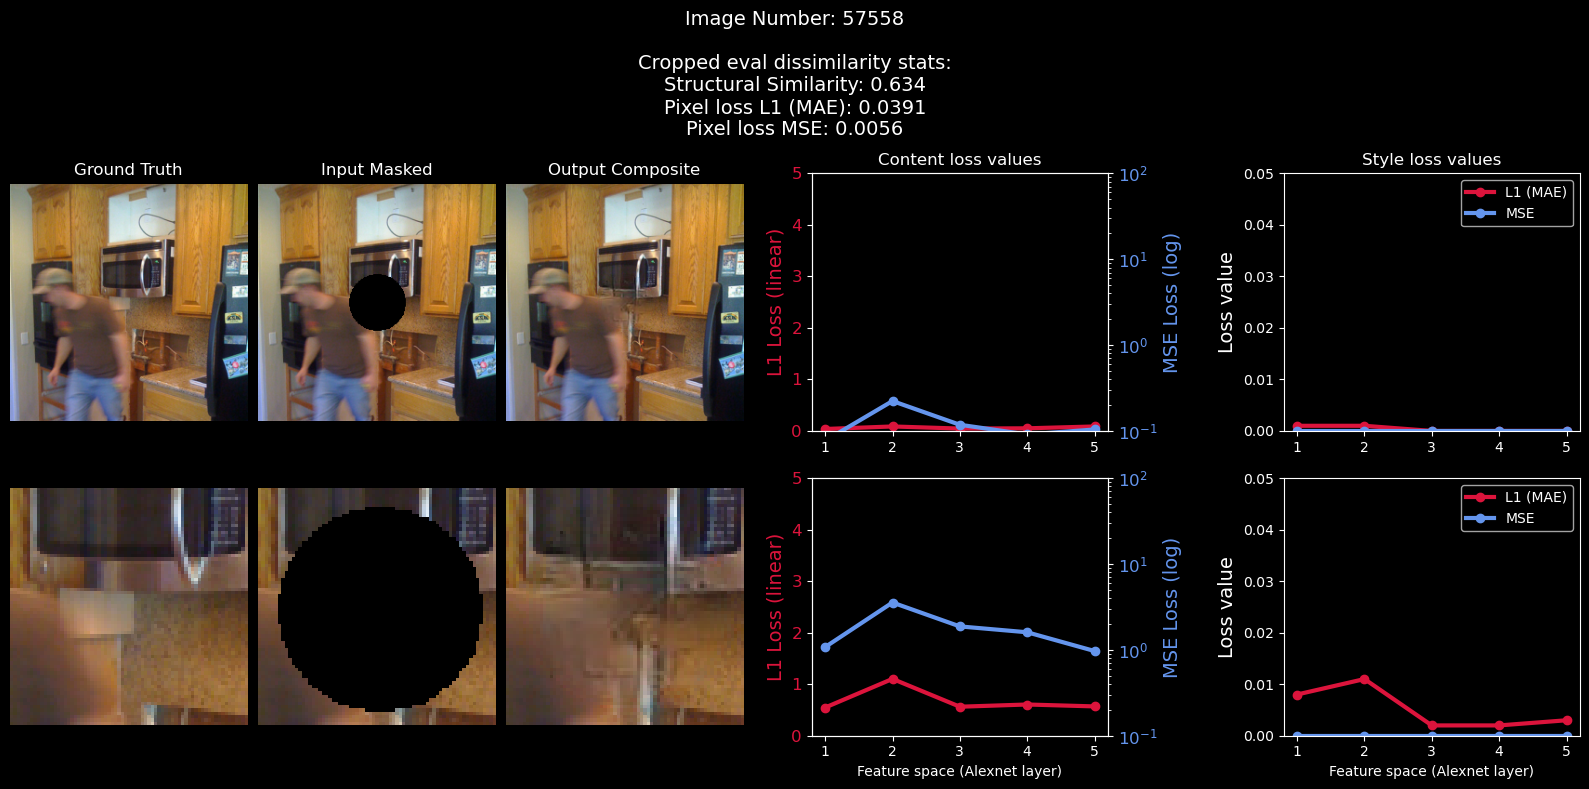

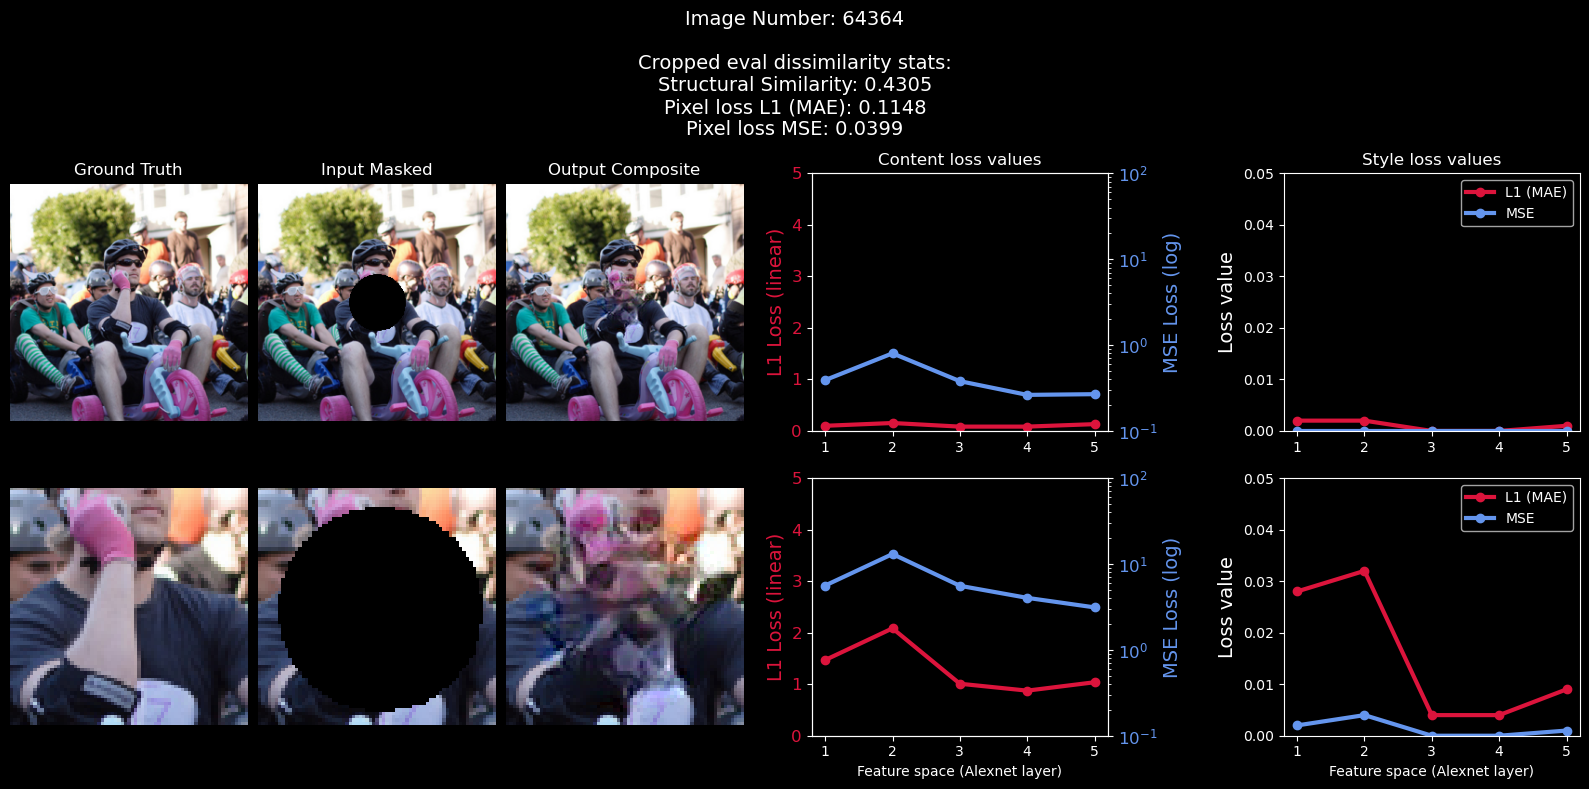

In [34]:
# WORKS! Now it would be nice to also check the images for a subject's specific design matrix
_ = NSP.stimuli.predplot(subject='subj01', start_img=0, n_imgs=2, mask_loc='center', ecc_max=1, 
               select_ices='random', cnn_type='alex', pretrain_version='places20k', 
               eval_mask_factor=1.2, log_y_MSE='y')

In [13]:
R2_dict = NSP.cortex.nsd_R2_dict(roi_masks, glm_type='hrf')
prf_rsq_dict = NSP.cortex.rsquare_selection(prf_dict, 1000, n_subjects=8, dataset='prf')
nsd_rsq_dict = NSP.cortex.rsquare_selection(R2_dict, 1000, n_subjects=8, dataset='nsd')

Subject: subj01, Voxel 1 out of 10 found
Subject: subj01, Voxel 2 out of 10 found
Subject: subj01, Voxel 3 out of 10 found
Subject: subj01, Voxel 4 out of 10 found
Subject: subj01, Voxel 5 out of 10 found
Subject: subj01, Voxel 6 out of 10 found
Subject: subj01, Voxel 7 out of 10 found
Subject: subj01, Voxel 8 out of 10 found
Subject: subj01, Voxel 9 out of 10 found
Subject: subj01, Voxel 10 out of 10 found


Currently 10 prfs found
Subject: subj02, Voxel 1 out of 10 found
Subject: subj02, Voxel 2 out of 10 found
Subject: subj02, Voxel 3 out of 10 found
Subject: subj02, Voxel 4 out of 10 found
Subject: subj02, Voxel 5 out of 10 found
Subject: subj02, Voxel 6 out of 10 found
Subject: subj02, Voxel 7 out of 10 found
Subject: subj02, Voxel 8 out of 10 found
Subject: subj02, Voxel 9 out of 10 found
Subject: subj02, Voxel 10 out of 10 found


Currently 20 prfs found
Subject: subj03, Voxel 1 out of 10 found
Subject: subj03, Voxel 2 out of 10 found
Subject: subj03, Voxel 3 out of 10 found
Sub

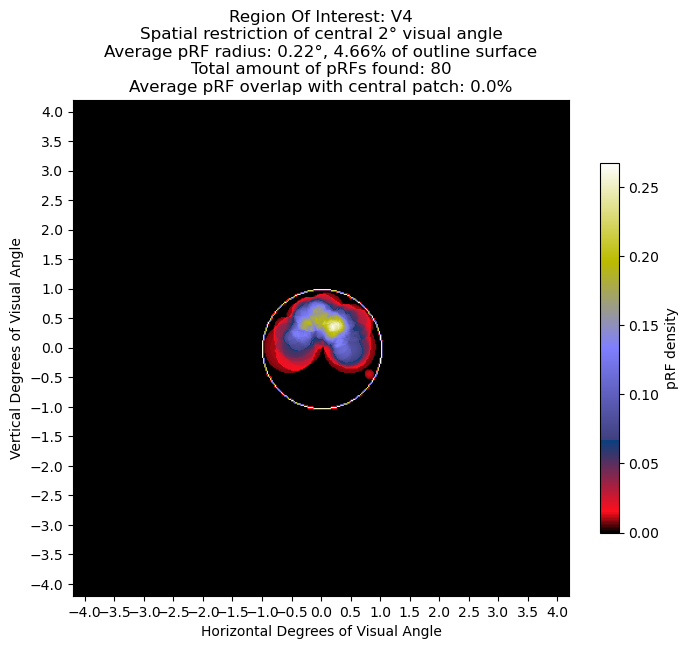

Runtime: 124.022 seconds
There were <built-in function iter> out of 3976 pRFs considered


In [18]:

start = time.time()
# heatmap, iter, end_premat, roi, prf_sizes, avg_surf, total_prfs, prfmask_dict, prf_overlaps
end_premat = NSP.cortex.prf_heatmap(10, binary_masks=roi_masks, prf_proc_dict=prf_dict,
                                                        mask_type='cut_gaussian', cmap='gist_stern', print_prog='y', 
                                                        roi='V4', sigma_min=0, sigma_max = 1, ecc_max = 1, subjects='all', 
                                                        outline_degs = 1, 
                                                        filter_dict = nsd_rsq_dict, ecc_strict = 'y')[2]

end = time.time()
print("Runtime:", np.round(end - start, 3), "seconds")

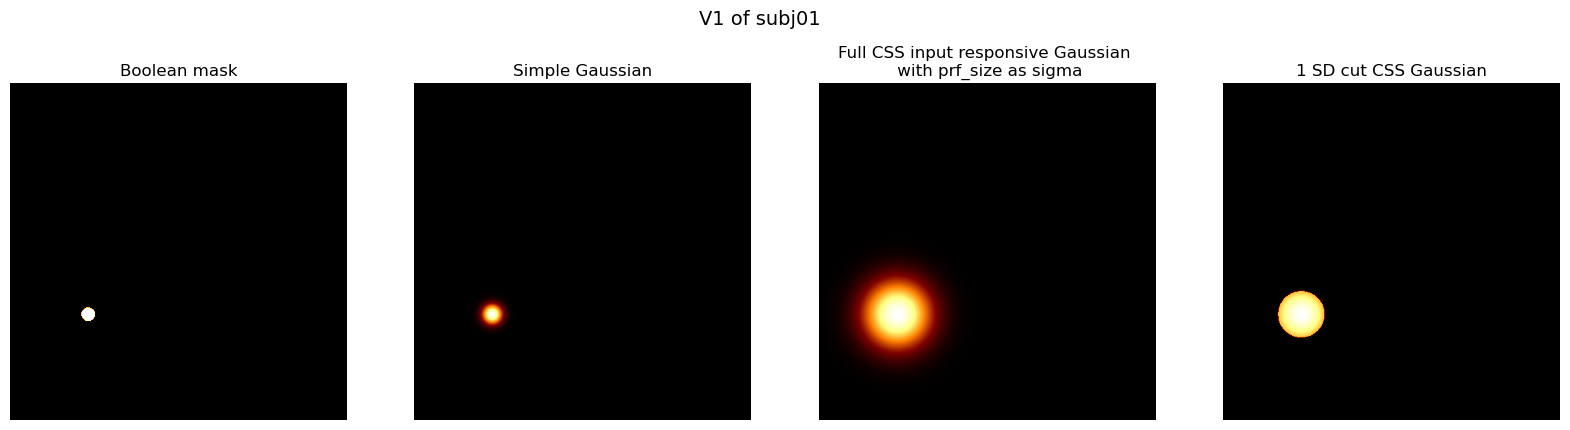

In [65]:
NSP.explore.compare_masks(roi_masks, prf_dict)

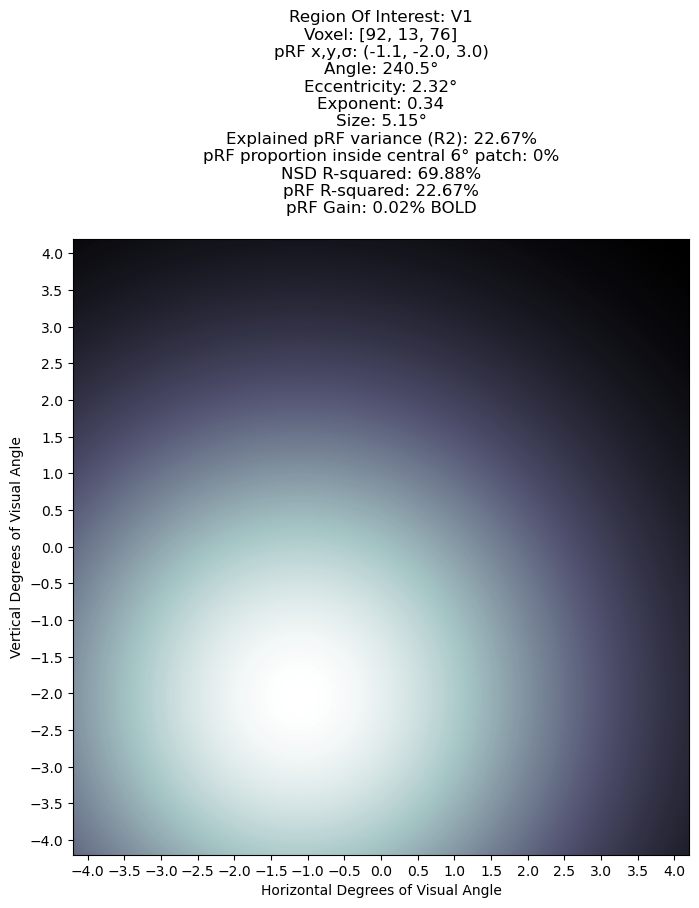

In [47]:
out = NSP.cortex.get_mask(dim = 425, subject = 'subj01', binary_masks = roi_masks, 
                                        prf_proc_dict = prf_dict, type='gaussian', roi='V1',
                                        plot = 'y', excl_reason = 'n', sigma_min=2.9, sigma_max = 3,
                                        ecc_min = 2, ecc_max = 3,
                                        angle_min = 0, angle_max = 360)

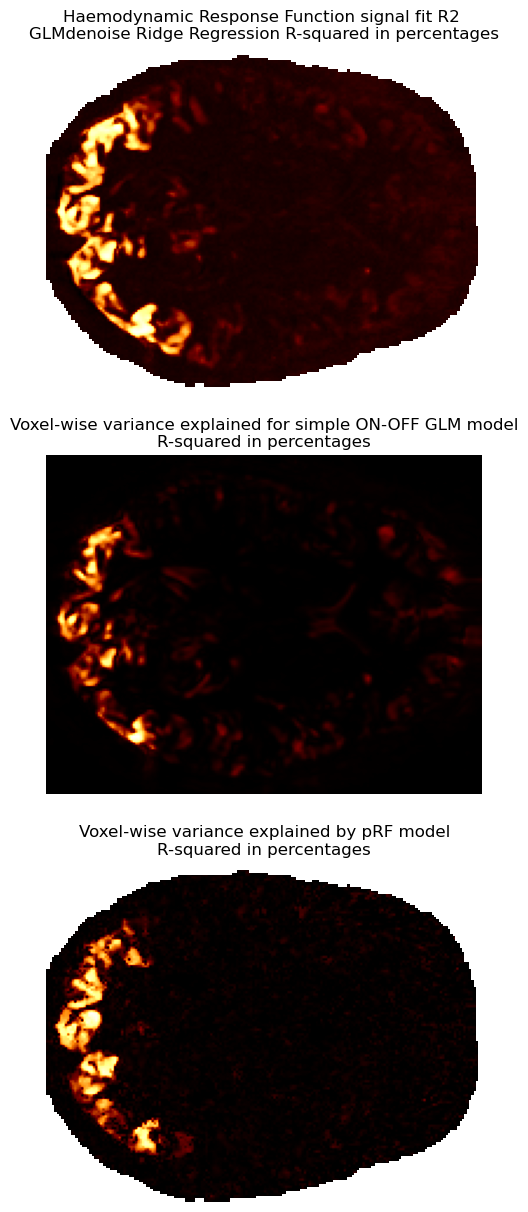

In [44]:
NSP.explore.compare_NSD_R2s(roi_masks, prf_dict, 'subj01', 76)

/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rfpred/envs/rfenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['input', 'Conv2d_1', 'ReLU_1', 'MaxPool2d_1', 'Conv2d_2', 'ReLU_2', 'MaxPool2d_2', 'Conv2d_3', 'ReLU_3', 'Conv2d_4', 'ReLU_4', 'Conv2d_5', 'ReLU_5', 'MaxPool2d_3', 'Dropout_1', 'Linear_1', 'ReLU_6', 'Dropout_2', 'Linear_2', 'ReLU_7', 'Linear_3']
['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


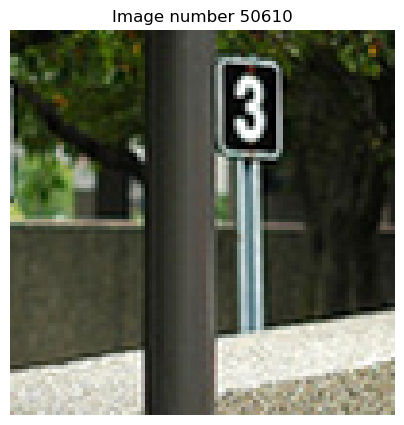

In [17]:
_ = NSP.stimuli.show_stim(img_no=img_ids[0], small=True, crop=True)

ReLU_5


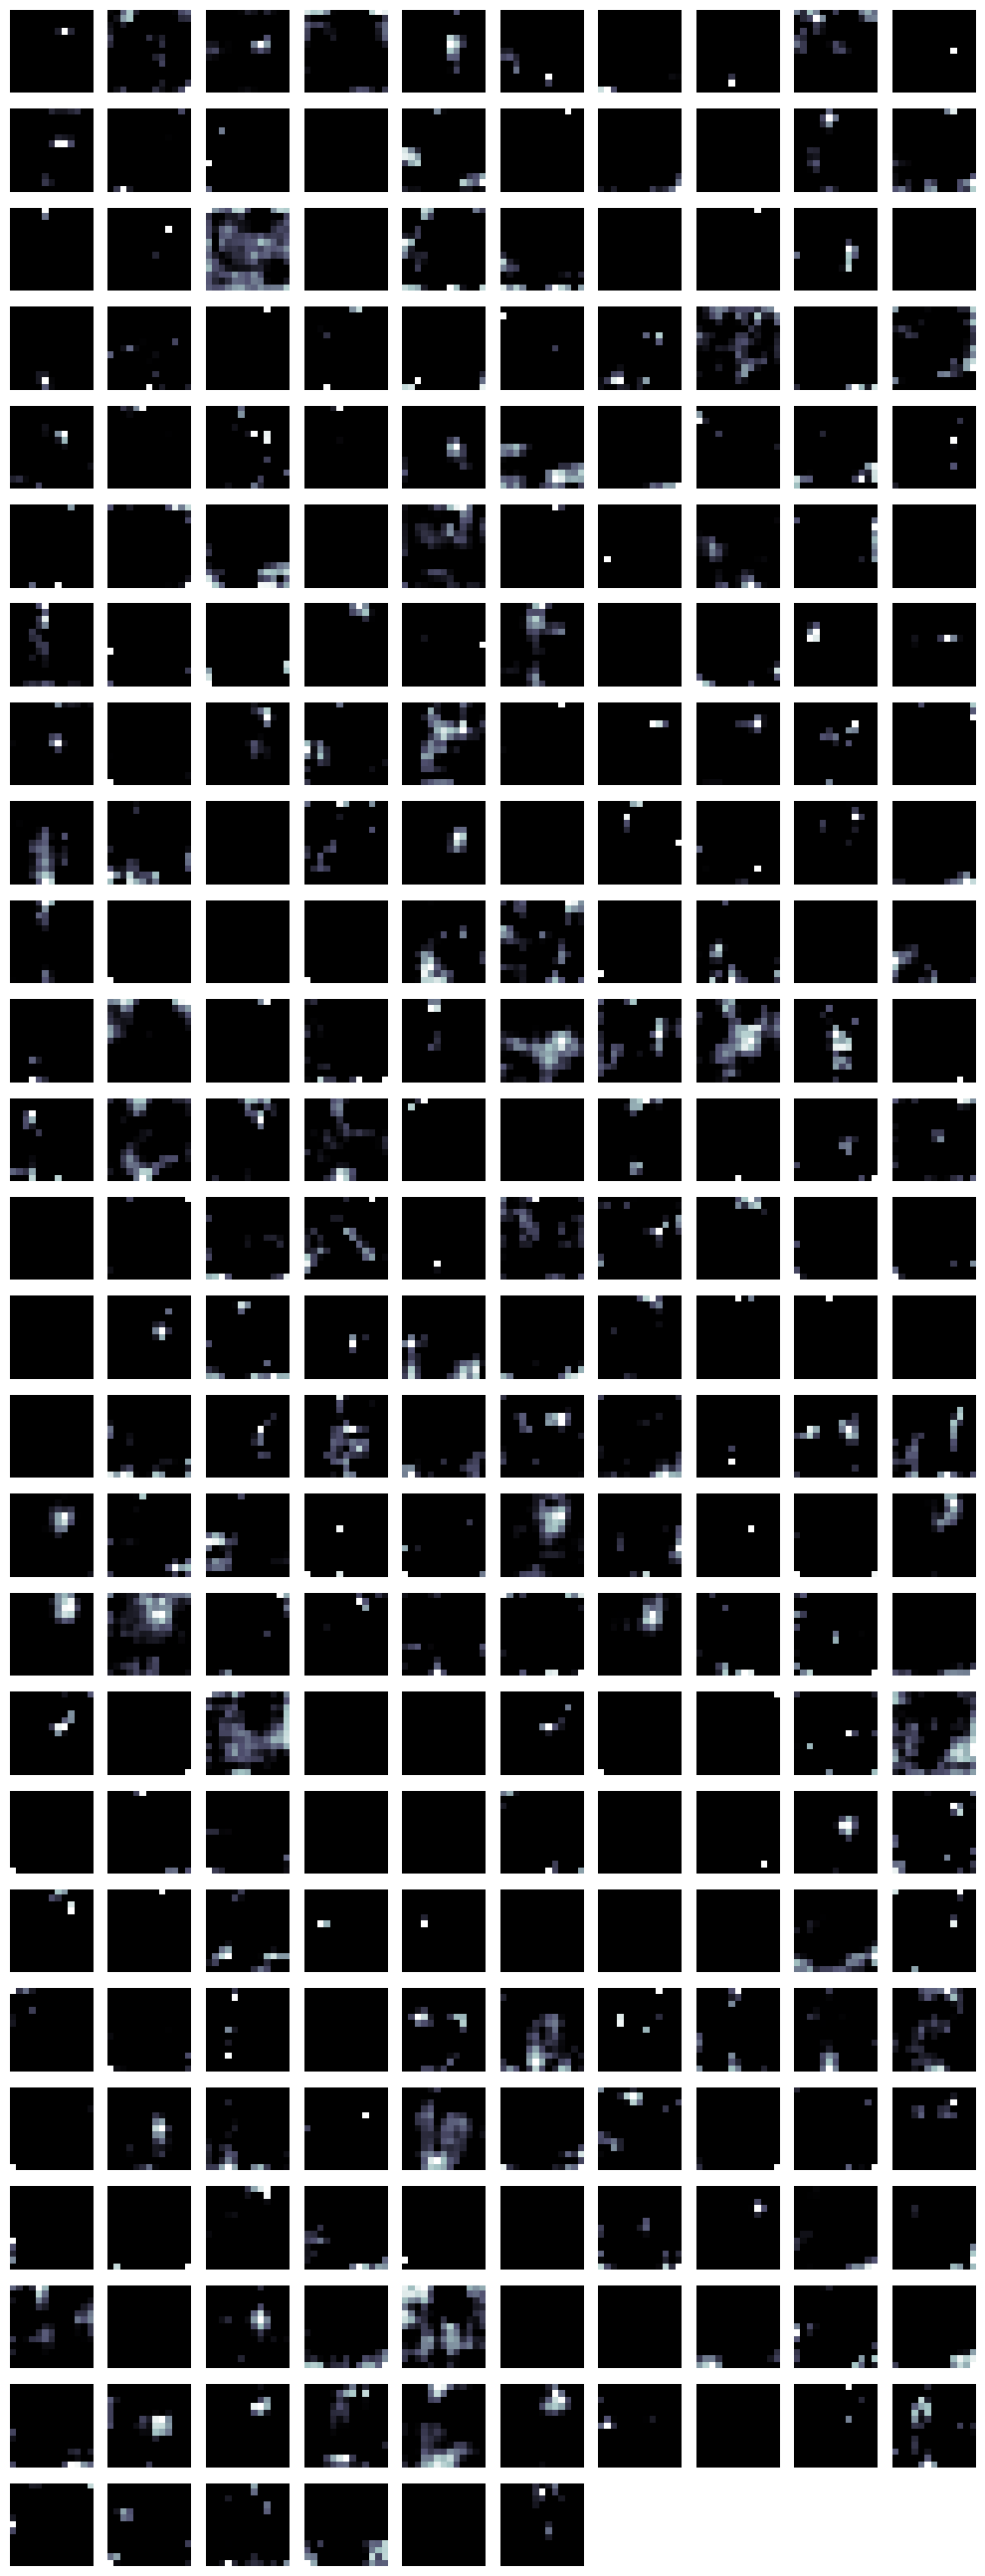

In [18]:
# Plot the feature maps
print(layname)
NSP.stimuli.plot_features(which_img=0, layer=lay, layer_type=layname, img_ids=img_ids, features=feature, num_cols=10, random_cmap=False)

In [35]:
# rois, roi_masks = NSP.visrois_dict()
# prf_dict = NSP.prf_dict(rois, roi_masks)

anats = NSP.anat_templates(prf_dict)

In [37]:
del rois, roi_masks, prf_dict, anats

In [46]:
import psutil
import os
# del NSP
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Memory usage: {process.memory_info().rss / 1024 ** 2} MB")

print_memory_usage()

Memory usage: 2329.828125 MB


In [11]:
def print_user_variables():
    print("\n".join("%s: %s" % item for item in globals().items() if not item[0].startswith("__")))

print_user_variables()

_ih: ['', 'class DataFetch():\n    \n    def __init__(self):\n        pass\n    # Function to get the visual contrast features and predictability estimates\n    # IMPROVE: make sure that it also works for all subjects later on. Take subject arg, clean up paths.\n    def features(self):\n        feature_paths = [\n            \'./data/custom_files/all_visfeats_rms.pkl\',\n            \'./data/custom_files/all_visfeats_rms_crop_prior.pkl\',\n            \'/home/rfpred/data/custom_files/all_visfeats_scce.pkl\',\n            \'/home/rfpred/data/custom_files/all_visfeats_scce_large.pkl\',\n            \'/home/rfpred/data/custom_files/subj01/pred/all_predestims.h5\'\n        ]\n        return {os.path.basename(file): self._fetch_file(file) for file in feature_paths}\n    # Function to get the pRF-based voxel selections\n    # IMPROVE: make sure that it also works for all subjects later on. Take subject arg, clean up paths.\n    def prf_selections(self):\n        prf_selection_paths = [\n    

In [42]:
import psutil
import os

def print_cpu_usage():
    process = psutil.Process(os.getpid())
    print(f"CPU usage: {process.cpu_percent()}%")

print_cpu_usage()

CPU usage: 0.0%


In [32]:
import sys

x = "Hello, world!"
print(f"Memory usage of x: {sys.getsizeof(heatmap)} bytes")

def inbytes(x):
    return sys.getsizeof(x)


Memory usage of x: 1445128 bytes


180625

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# AlexNet(
#   (features): Sequential(
#     (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
#     (1): ReLU(inplace=True)
#     (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#     (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
#     (4): ReLU(inplace=True)
#     (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#     (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (7): ReLU(inplace=True)
#     (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (9): ReLU(inplace=True)
#     (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (11): ReLU(inplace=True)
#     (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
#   )
#   (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
#   (classifier): Sequential(
#     (0): Dropout(p=0.5, inplace=False)
#     (1): Linear(in_features=9216, out_features=4096, bias=True)
#     (2): ReLU(inplace=True)
#     (3): Dropout(p=0.5, inplace=False)
#     (4): Linear(in_features=4096, out_features=4096, bias=True)
#     (5): ReLU(inplace=True)
#     (6): Linear(in_features=4096, out_features=1000, bias=True)
#   )
# )